In [1]:
import os
import glob
import json
import h5py
import copy

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.gridspec as gridspec

from pipeline.python.classifications import utils as util
from pipeline.python.classifications import test_responsivity as resp
from pipeline.python.utils import label_figure, natural_keys, convert_range

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


In [2]:

def convert_range(oldval, newmin=None, newmax=None, oldmax=None, oldmin=None):
    oldrange = (oldmax - oldmin)
    newrange = (newmax - newmin)
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval

In [3]:
%matplotlib notebook

In [4]:
!pip install matplotlib_venn

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:

def do_retino_analysis_on_raw(exp):
    n_frames = exp.data.info['stimulus']['nframes']
    n_files = exp.data.info['ntiffs']
    fr = exp.data.info['stimulus']['frame_rate']
    stimfreq = exp.data.info['stimulus']['stimfreq']

    # label frequency bins
    freqs = np.fft.fftfreq(n_frames, float(1/fr))
    sorted_freq_ixs = np.argsort(freqs)
    freqs=freqs[sorted_freq_ixs]
    print(freqs)

    # exclude DC offset from data
    freqs=freqs[int(np.round(n_frames/2.))+1:]

    # Identify freq idx:
    stim_freq_ix=np.argmin(np.absolute(freqs-stimfreq))#find out index of stimulation freq
    top_freq_ix=np.where(freqs>1)[0][0]#find out index of 1Hz, to cut-off zoomed out plot
    print("Target freq: %.3f Hz" % (freqs[stim_freq_ix]))
    

    trials_by_cond = exp.data.info['trials']
    trial_nums = np.array([v for k,v in trials_by_cond.items()])
    trial_nums = sorted(trial_nums.flatten())

    nframes_total, nrois = exp.data.traces.shape
    magratios=[]
    phases=[]
    conds=[]
    traces={}
    for curr_cond in trials_by_cond.keys():
        avg_traces = []
        for rid in exp.data.traces.columns:
            tracemat = pd.DataFrame(np.reshape(exp.data.traces[rid], (n_frames, n_files), order='F'),\
                                    columns=trial_nums)
            avg = tracemat[trials_by_cond[curr_cond]].mean(axis=1)
            avg_traces.append(avg)
        avg_traces = pd.DataFrame(np.array(avg_traces).T, columns=exp.data.traces.columns)
        traces[curr_cond] = avg_traces

        magratio_array, phase_array = do_fft_analysis(avg_traces, sorted_freq_ixs, stim_freq_ix, n_frames)

        magratios.append(magratio_array)
        phases.append(phase_array)
        conds.append(curr_cond)
        
    magratios = pd.DataFrame(np.array(magratios).T, columns=conds)
    phases = pd.DataFrame(np.array(phases).T, columns=conds)
    
    return magratios, phases, traces

def do_fft_analysis(avg_traces, sorted_freq_ixs, stim_freq_ix, n_frames):
    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results)
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[sorted_freq_ixs]
    phase_data = phase_data[sorted_freq_ixs]

    # exclude DC offset from data
    mag_data = mag_data[int(np.round(n_frames/2.))+1:, :]
    phase_data = phase_data[int(np.round(n_frames/2.))+1:, :]

    #unpack values from frequency analysis
    mag_array = mag_data[stim_freq_ix, :]
    phase_array = phase_data[stim_freq_ix, :]

    #get magnitude ratio
    tmp = np.copy(mag_data)
    #tmp = np.delete(tmp,freq_idx,0)
    nontarget_mag_array=np.sum(tmp,0)
    magratio_array=mag_array/nontarget_mag_array

    return magratio_array, phase_array


# Select datasets

In [94]:
rootdir = '/n/coxfs01/2p-data'

animalid = 'JC099'
session = '20190617'
fov = 'FOV1_zoom2p0x'
traceid = 'traces001'


In [95]:
#reload(util)

In [96]:
# Create output_dir

output_dir = os.path.join(rootdir, animalid, session, fov, 'summaries')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(output_dir)

/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/summaries


In [97]:
session_outfile = os.path.join(output_dir, 'sessiondata.pkl')
create_new = True

if os.path.exists(session_outfile) and create_new is False:
    print("loading session object...")
    with open(session_outfile, 'rb') as f:
        S = pkl.load(f)

else:
    print("creating new session object...")
    S = util.Session(animalid, session, fov, rootdir=rootdir)
    S.load_data(traceid=traceid, trace_type='corrected')
    
    # Save session data object
    with open(session_outfile, 'wb') as f:
        pkl.dump(S, f, protocol=pkl.HIGHEST_PROTOCOL)
    

creating new session object...
[JC099] 20190617 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
Found epi sessions: []
No EPI maps found for session: %s * (trying to use tmp session boundaries file)
('-- getting screen info from:', ['/n/coxfs01/2p-data/JC099/epi_maps/screen_boundaries_tmp.json'])
*********************************
{   'azimuth': 117.5584,
    'bb_left': -58.7792,
    'bb_lower': -33.6615,
    'bb_right': 58.7792,
    'bb_upper': 33.6615,
    'elevation': 67.323,
    'resolution': [1024, 768]}
*********************************
('center 2 Top/Anterior:', 33.6615, 58.7792)
Loading data: traces001 - corrected
[rfs10] creating experiment object.
... [combined_rfs10_static] getting data path.
... renaming experiment to run name: combined_rfs10_static
... loading data array (combined_rfs10_static - datasets.npz)
[gratings] creating experiment object.
... [combined_gratings_static] getting data path.
... renaming experiment to run name: combined_gratings_s

In [98]:
print(S.experiments.keys())
data_identifier = '|'.join([S.animalid, S.session, S.fov, S.traceid, S.rois])
data_identifier


['gratings', 'rfs10', 'retino', 'blobs']


u'JC099|20190617|FOV1_zoom2p0x|traces001|rois001'

In [99]:
# excluded_params = ['position']
# exp = S.experiments['rfs']
# all_params = [c for c in exp.data.sdf.columns if c not in excluded_params]
# tested_params = [c for c in all_params if len(exp.data.sdf[c].unique()) > 1]
# stim_params = dict((str(p), sorted(exp.data.sdf[p].unique())) for p in tested_params)
# stim_params
        

In [100]:
def load_RF_fits(exp):
    #assert 'rfs' in S.experiments['rfs'].name, "This is not a RF experiment object! %s" % exp.name
    rf_fits = sorted(glob.glob(os.path.join(exp.source.split('/data_arrays/')[0],
                                     'figures', 'receptive_fields', 'rfs_2dgaus*', '*.pkl')), key=natural_keys)
    if len(rf_fits) > 1:
        print("EXP: %s - more than 1 RF fit result found:" % exp.name)
        for r, ri in enumerate(rf_fits):
            print(r, ri)
        sel = input("-- Select IDX of fits to use: ")
        rfs_fpath = rf_fits[int(sel)]
    else:
        rfs_fpath = rf_fits[0]
    with open(rfs_fpath, 'rb') as f:
        rffits = pkl.load(f)
        
    return rffits

# Get list of "responsive cells" for each experiment

In [101]:
#reload(resp)

In [102]:
responsive_test = 'ROC'

mag_ratio_thr = 0.01
rf_fit_thr = 0.5

roi_lists={}
exp_gdfs={}
for exp_name, exp in S.experiments.items():
        
    print("[%s] Loading roi lists..." % exp_name)
    curr_roi_list = []
    
    # Load data:
    exp.data.traces, exp.data.labels = util.check_counts_per_condition(exp.data.traces, exp.data.labels)

    # Load list of "visually responsive" cells
    if exp_name in ['blobs'] or (exp_name == 'gratings' and int(S.session) >= 20190511):
        curr_base_dir = exp.source.split('/data_arrays/')[0]
        try:
            curr_stats_dir = os.path.join(curr_base_dir, 'summary_stats', responsive_test)
            stats_fpath = glob.glob(os.path.join(curr_stats_dir, '*results*.pkl'))
            assert len(stats_fpath) > 0, "No stats results found for: %s" % curr_stats_dir
            with open(stats_fpath[0], 'rb') as f:
                roistats = pkl.load(f)
            curr_roi_list = [r for r, res in roistats.items() if res['pval'] < 0.05]
        except Exception as e:
            print e
            print("-- Unable to load stats: %s [%s]" % (responsive_test, exp_name))
    else:
        if 'rfs' in exp_name or (exp_name == 'gratings' and int(S.session) < 20190511):
            if (exp_name == 'gratings' and int(S.session) < 20190511):
                print "OLD"
            try:
                rffits = load_RF_fits(S.experiments[exp_name])
                curr_roi_list = [r for r, res in rffits['fits'].items() if res['fit_r']['r2'] >= rf_fit_thr]
                if exp_name == 'gratings':
                    exp_name = 'rfs'
            except Exception as e:
                print e
                print("-- No RF fits! [%s]" % exp_name)
        elif 'retino' in exp_name:
            #print("-- Not implemented -- [%s]" % exp_name)
            magratios, phases, traces = do_retino_analysis_on_raw(S.experiments['retino'])
            curr_roi_list = [r for r in magratios.index.tolist() if any(magratios.loc[r] > mag_ratio_thr)]

    roi_lists[exp_name] = curr_roi_list
    
    if 'retino' not in exp_name:
        exp.load(trace_type='dff')
        exp_gdfs[exp_name] = resp.group_roidata_stimresponse(exp.data.traces[curr_roi_list], exp.data.labels, roi_list=curr_roi_list)
    else:
        exp_gdfs[exp_name] = magratios.max(axis=1)
        

[gratings] Loading roi lists...
... loading data array (combined_gratings_static - datasets.npz)
[rfs10] Loading roi lists...
EXP: combined_rfs10_static - more than 1 RF fit result found:
(0, '/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_8577f8_traces001_abea5d_traces001_794ad4_traces001_b2805d/figures/receptive_fields/rfs_2dgaus_responsemin_snr1.50_no_trim_/RESULTS_rfs_2dgaus_responsemin_snr1.50_no_trim_.pkl')
(1, '/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_8577f8_traces001_abea5d_traces001_794ad4_traces001_b2805d/figures/receptive_fields/rfs_2dgaus_responsemin_zscore0.00_no_trim_/RESULTS_rfs_2dgaus_responsemin_zscore0.00_no_trim_.pkl')
-- Select IDX of fits to use: 1
... loading data array (combined_rfs10_static - datasets.npz)
[retino] Loading roi lists...
[-22.31640161 -22.29640484 -22.27640806 ...,  22.27640806  22.29640484
  22.31640161]
Target freq: 0.240 Hz
[blobs] Loading roi lists...
incorre

# Compare rois

In [103]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from matplotlib.patches import Ellipse, Rectangle

from shapely.geometry.point import Point
from shapely import affinity
from matplotlib.patches import Polygon

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator

import matplotlib_venn as mpvenn
import itertools


In [104]:

def RF_results_to_df(rffits, roi_list=None):
    if roi_list is None:
        roi_list = sorted(rffits.keys())
        
    rf_fits_df = pd.DataFrame({'x0': [rffits['fits'][r]['x0'] for r in roi_list],
                               'y0': [rffits['fits'][r]['y0'] for r in roi_list],
                               'sigma_x': [rffits['fits'][r]['sigma_x'] for r in roi_list],
                               'sigma_y': [rffits['fits'][r]['sigma_y'] for r in roi_list],
                               'theta': [rffits['fits'][r]['theta'] for r in roi_list] },
                              index=roi_list)

    x0, y0, sigma_x, sigma_y = fitrf.convert_fit_to_coords(rf_fits_df, rffits['row_vals'], rffits['col_vals'])
    rf_fits_df['x0'] = x0
    rf_fits_df['y0'] = y0
    rf_fits_df['sigma_x'] = sigma_x
    rf_fits_df['sigma_y'] = sigma_y
    
    return rf_fits_df


def create_ellipse(center, lengths, angle=0):
    """
    create a shapely ellipse. adapted from
    https://gis.stackexchange.com/a/243462
    """
    circ = Point(center).buffer(1)
    ell = affinity.scale(circ, int(lengths[0]), int(lengths[1]))
    ellr = affinity.rotate(ell, angle)
    return ellr

from shapely.geometry import box


def check_path_intersection(ref_patch, sample_patch, all_contained=False):
    ref_path = ref_patch.get_patch_transform().transform_path(ref_patch.get_path())

    verts = sample_patch.get_path().vertices
    trans = sample_patch.get_patch_transform()
    pts = trans.transform(verts)
    
    if all_contained:
        return all(g_path.contains_points(pts))
    else:
        return any(g_path.contains_points(pts))

# # To just check intersection True/False

# ell = Ellipse((x0, y0), abs(sx)*sigma_scale, abs(sy)*sigma_scale, angle=np.rad2deg(th),
#                alpha=0.5, edgecolor='k', lw=0.2, facecolor='none') #theta_f)
# ax.add_patch(ell)

# verts = ell.get_path().vertices
# trans = ell.get_patch_transform()
# pts = trans.transform(verts)

# if check_path_intersection(gratings_patch, ell, all_contained=False):
#     in_gratings.append(roi)
# if check_path_intersection(blobs_min_patch, ell, all_contained=False):
#     in_blobs_min.append(roi)
# if check_path_intersection(blobs_max_patch, ell, all_contained=False):
#     in_blobs_max.append(roi)


In [105]:
for exp_name, rlist in roi_lists.items():
    print('%s: %i rois' % (exp_name, len(rlist)))

blobs: 9 rois
gratings: 22 rois
rfs10: 15 rois
retino: 33 rois


#### Compare RFs if both rfs10 and rfs measured

In [106]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [108]:
compare_rf_exps = False
if 'rfs' in roi_lists.keys() and 'rfs10' in roi_lists.keys():
    print("Found expmts for both RFs and RFs10")
    rf_set_labels = ['rfs', 'rfs10']
    rf_sets = [set(roi_lists[k]) for k in rf_set_labels]
    
    ## Get distribution of RF sizes
    rfits = load_RF_fits(S.experiments['rfs'])
    rfits10 = load_RF_fits(S.experiments['rfs10'])

    rfits_df = RF_results_to_df(rfits, roi_list=sorted(roi_lists['rfs']))
    xres = list(set(np.diff(rfits['col_vals'])))[0]
    yres = list(set(np.diff(rfits['row_vals'])))[0]
    print("rfs: X- and Y-res: (%i, %i)" % (xres, yres))

    rfits_df10 = RF_results_to_df(rfits10, roi_list=sorted(roi_lists['rfs10']))
    xres10 = list(set(np.diff(rfits10['col_vals'])))[0]
    yres10 = list(set(np.diff(rfits10['row_vals'])))[0]
    print("rfs10: X- and Y-res: (%i, %i)" % (xres10, yres10))

    compare_rf_exps = True



In [109]:
if compare_rf_exps:

    rf_colors = {'rfs': 'red', 'rfs10': 'cornflowerblue'}
    sigma_scale = 2.36

    #fig, axes = pl.subplots(2,5, figsize=(10,4))
    fig = pl.figure(figsize=(10, 6))
    fig.patch.set_alpha(1)

    ## Venn diagram of overlap ROIs:
    ax = pl.subplot2grid((2, 5), (0, 0), colspan=1, rowspan=1)
    v = mpvenn.venn2(rf_sets, set_labels=rf_set_labels, ax=ax)
    for p in v.patches:
        p.set_alpha(0)
    c=mpvenn.venn2_circles(rf_sets, ax=ax) #set_labels=roi_set_labels, ax=ax)
    for ci in range(len(c)):
        c[ci].set_edgecolor(rf_colors[rf_set_labels[ci]])
        c[ci].set_alpha(0.5)

    ## Distribution of peak dF/Fs:
    ax = pl.subplot2grid((2, 5), (0, 1), colspan=2, rowspan=1)
    peak_dfs = [exp_gdfs['rfs'].get_group(roi).groupby(['config']).mean()['meanstim'].max() for roi in roi_lists['rfs']]
    peak_dfs10 = [exp_gdfs['rfs10'].get_group(roi).groupby(['config']).mean()['meanstim'].max() for roi in roi_lists['rfs10']]
    weights_rfs = np.ones_like(peak_dfs) / float(len(peak_dfs))
    sns.distplot(peak_dfs, ax=ax, color=rf_colors['rfs'], label='rfs (n=%i)' % len(peak_dfs),
                 kde=False, hist=True,
                 hist_kws={'histtype': 'step', 'alpha': 0.5, 'weights': weights_rfs, 'normed':0, 'lw': 2})
    weights_rfs10 = np.ones_like(peak_dfs10) / float(len(peak_dfs10))
    sns.distplot(peak_dfs10, ax=ax, color=rf_colors['rfs10'], label='rfs10 (n=%i)' % len(peak_dfs10),
                 kde=False, hist=True,
                 hist_kws={'histtype': 'step', 'alpha': 0.5, 'weights': weights_rfs10, 'normed':0, 'lw': 2})
    ax.legend(loc='upper right', fontsize=6)
    ax.set_xlim([0, ax.get_xlim()[-1]])
    ax.set_xlabel('peak dF/F')
    ax.set_ylabel('fraction')
    #ax.set_ylim([0, max([max(peak_dfs), max(peak_dfs10)])])
    sns.despine(trim=True, offset=2)

    ## Distribution of avg RF size:
    ax = pl.subplot2grid((2, 5), (0, 3), colspan=2, rowspan=1)
    size_rfs = rfits_df[['sigma_x', 'sigma_y']].mean(axis=1)
    size_rfs10 = rfits_df10[['sigma_x', 'sigma_y']].mean(axis=1)
    weights_size_rfs = np.ones_like(size_rfs) / float(len(size_rfs))
    weights_size_rfs10 = np.ones_like(size_rfs10) / float(len(size_rfs10))
    sns.distplot(size_rfs, ax=ax, color=rf_colors['rfs'], label='rfs (avg. %.2f)' % np.mean(size_rfs),
                 kde=False, hist=True,
                 hist_kws={'histtype': 'step', 'alpha': 0.5, 'weights': weights_size_rfs, 'normed':0, 'lw': 2})
    sns.distplot(size_rfs10, ax=ax, color=rf_colors['rfs10'], label='rfs10 (avg. %.2f)' % np.mean(size_rfs10),
                 kde=False, hist=True,
                 hist_kws={'histtype': 'step', 'alpha': 0.5, 'weights': weights_size_rfs10, 'normed':0, 'lw': 2})
    ax.legend(loc='upper right', fontsize=6)
    ax.set_xlim([0, ax.get_xlim()[-1]+5])
    ax.set_xlabel('average RF size')
    ax.set_ylabel('fraction')
    sns.despine(trim=True, offset=2)



    ## Distribution of avg RF size:
    rois_in_both_rfs = intersection(rfits_df.index.tolist(), rfits_df10.index.tolist())
    rf_params=['sigma_x', 'sigma_y', 'x0', 'y0', 'theta']
    for ai in range(len(rf_params)):
        ax = pl.subplot2grid((2, 5), (1, ai), colspan=1, rowspan=1)
        ax.set_title(rf_params[ai])

        if rf_params[ai] == 'theta':
            rf_vals = [np.rad2deg(th) % 360. for th in rfits_df[rf_params[ai]][rois_in_both_rfs]]
            rf_vals10 = [np.rad2deg(th) % 360. for th in rfits_df10[rf_params[ai]][rois_in_both_rfs]]
        else:
            rf_vals = rfits_df[rf_params[ai]][rois_in_both_rfs]
            rf_vals10 = rfits_df10[rf_params[ai]][rois_in_both_rfs]
        ax.scatter(rf_vals, rf_vals10,
                   s=5, marker='o', c='k', alpha=0.5)
        ax.set_xlabel('rfs'); ax.set_ylabel('rfs10');
        minv = min([min(rf_vals), min(rf_vals10)])
        maxv = max([max(rf_vals), max(rf_vals10)])
        ax.set_xlim([minv, maxv])
        ax.set_ylim([minv, maxv])
        #sns.despine(trim=True, ax=ax)
        ax.set_aspect('equal')
    pl.subplots_adjust(wspace=1, hspace=.1, left=0.1)

    label_figure(fig, data_identifier)

    pl.savefig(os.path.join(output_dir, 'compare_rfs_vs_rfs10.png'))

#### Compare stimulus types

In [110]:
rf_exp_name = 'rfs10'

event_expmts = sorted([rf_exp_name, 'gratings', 'blobs'])

tmp_roi_list = [v for k, v in roi_lists.items()]
all_rois = list(set(itertools.chain(*tmp_roi_list)))

tmp_roi_list = [roi_lists[k] for k in event_expmts]
event_rois = list(set(itertools.chain(*tmp_roi_list)))


['blobs', 'gratings', 'rfs10']


<IPython.core.display.Javascript object>


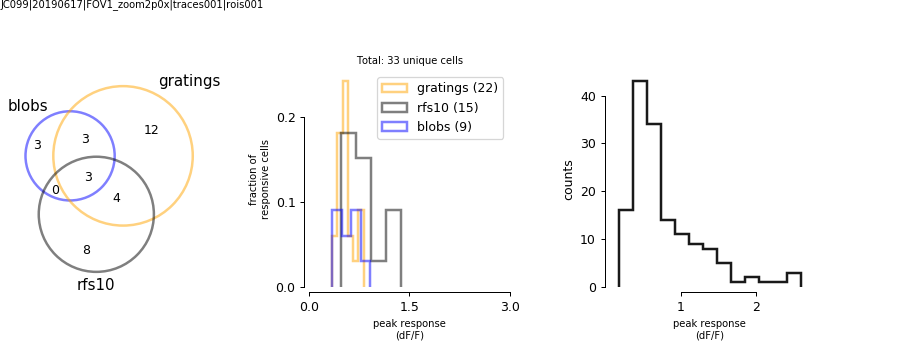

In [111]:

exp_colors= {rf_exp_name: 'black',
            'gratings': 'orange',
             'blobs': 'blue'}
#              'retino': 'gray'}

roi_sets = [set(roi_lists[k]) for k in event_expmts]
roi_set_labels = copy.copy(event_expmts)
print(roi_set_labels)

fig, axes = pl.subplots(1,3, figsize=(10,4))
fig.patch.set_alpha(1)

ax = axes[0]
v = mpvenn.venn3(roi_sets, set_labels=roi_set_labels, ax=ax)
# for pid, ename in zip(['A', 'B', 'C'], roi_set_labels):
#     #v.get_patch_by_id(pid).set_color(exp_colors[ename])
#     v.get_patch_by_id(pid).set_alpha(0)
for pid in v.id2idx.keys():
    #v.get_patch_by_id(pid).set_color(exp_colors[ename])
    v.get_patch_by_id(pid).set_alpha(0)

c=mpvenn.venn3_circles(roi_sets, ax=ax) #set_labels=roi_set_labels, ax=ax)
for ci in range(len(c)):
    c[ci].set_edgecolor(exp_colors[roi_set_labels[ci]])
    c[ci].set_alpha(0.5)
    
#ax.set_title('Event-triggered expmts: %i cells' % len(event_rois), fontsize=8)
#v.get_patch_by_id('rfs').set_color('black')


# Fraction of cells:
ax = axes[1]
for ename in exp_colors.keys():
    if 'retino' in ename:
        peak_values = exp_gdfs[ename].values * 100.
    else:
        peak_values = exp_gdfs[ename].max()['meanstim'].values
    weights = np.ones_like(peak_values) / float(len(event_rois))
    exp_str = '%s (%i)' % (ename, len(peak_values))
    sns.distplot(peak_values, label=exp_str, ax=ax, norm_hist=0, kde=False,
                 rug=False, rug_kws={"alpha": 0.5},
                 hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.5,
                         'weights': weights, 'normed': 0, "color": exp_colors[ename]})
    
ax.set_xlabel('peak response\n(dF/F)', fontsize=8)
ax.set_ylabel('fraction of\nresponsive cells', fontsize=8)
ax.legend()
ax.set_xlim([min([0, ax.get_xlim()[0]]), max([3, ax.get_xlim()[1]])])
ax.xaxis.set_major_locator(MaxNLocator(2))
ax.yaxis.set_major_locator(MaxNLocator(3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
sns.despine(trim=True, offset=4, ax=ax)
ax.set_title('Total: %i unique cells' % len(event_rois), fontsize=8)

# ALL responses -- counts of cells
ax = axes[2]
all_values = []
for ename, gdf in exp_gdfs.items():
    if 'retino' in ename:
        all_values.extend( gdf.values * 100.)
    else:
        all_values.extend(gdf.max()['meanstim'].values)
#weights = np.ones_like(all_values) / float(len(all_values))
sns.distplot(all_values, ax=ax, norm_hist=0, kde=False,
            rug=False,
            hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.9, # 'weights': weights, 
                        'normed': 0, "color": 'k'}) #[ename]})
sns.despine(trim=True, offset=4, ax=ax)
ax.set_xlabel('peak response\n(dF/F)', fontsize=8)
ax.set_ylabel('counts')

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.01, bottom=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(output_dir, "cell_counts_peak_dFF_w%s.png" % rf_exp_name))

# Visualize receptive field coverage

In [112]:
exp = S.experiments[rf_exp_name]
rois = roi_lists[rf_exp_name]
print(len(rois))

15


In [113]:
S.screen

{'aspect': 0.5726770694395296,
 'azimuth': 'right',
 'bounding_box': [None, None, None, None],
 'elevation': 'top',
 'height': 67.323,
 'linmaxH': 33.661499999999997,
 'linmaxW': 58.779200000000003,
 'linminH': -33.661499999999997,
 'linminW': -58.779200000000003,
 'resolution': [1024, 768],
 'width': 117.5584}

In [114]:
# Get screen bounds: [bottom left upper right]
screen_bounds = [S.screen['linminH'], S.screen['linminW'], S.screen['linmaxH'], S.screen['linmaxW']]
screen_aspect = S.screen['resolution'][0] / S.screen['resolution'][1]

In [115]:
# Get stimulus positions - blobs and gratings only
xpositions=[]; ypositions=[];
for ex in ['blobs', 'gratings']:
    sdf = S.experiments[ex].data.sdf.copy()
    if ex == 'gratings': # deal with FF stimuli
        sdf = sdf[sdf['size']<200]
        sdf.pop('luminance')
    curr_xpos = sdf.dropna()['xpos'].unique()
    assert len(curr_xpos)==1, "[%s] more than 1 xpos found! %s" % (ex, str(curr_xpos))
    curr_ypos = sdf.dropna()['ypos'].unique()
    assert len(curr_ypos)==1, "[%s] more than 1 ypos found! %s" % (ex, str(curr_ypos))
    xpositions.append(curr_xpos[0])
    ypositions.append(curr_ypos[0])

xpos = list(set(xpositions))
assert len(xpos)==1, "blobs and gratings have different XPOS: %s" % str(xpos)
ypos = list(set(ypositions))
assert len(ypos)==1, "blobs and gratings have different YPOS: %s" % str(ypos)
xpos = xpos[0]
ypos = ypos[0]
print("Stimuli presented at coords: (%i, %i)" % (xpos, ypos))


Stimuli presented at coords: (25, -5)


In [116]:
# Get stimulus size(s):
gratings_sz = S.experiments['gratings'].data.sdf['size'].unique().min()
print("Gratings: min apertured size %i" % gratings_sz)

# Get blob size(s):
blobs_sz_min = S.experiments['blobs'].data.sdf.dropna()['size'].unique().min()
blobs_sz_max = S.experiments['blobs'].data.sdf.dropna()['size'].unique().max()
print("Blobs: min/max size = %i/%i" % (blobs_sz_min, blobs_sz_max))

Gratings: min apertured size 30
Blobs: min/max size = 10/50


### Load RF results

In [117]:
# Draw RFs
rffits = load_RF_fits(S.experiments[rf_exp_name])
rf_fits_df = RF_results_to_df(rffits, roi_list=sorted(roi_lists[rf_exp_name]))
xres = list(set(np.diff(rffits['col_vals'])))[0]
yres = list(set(np.diff(rffits['row_vals'])))[0]
sigma_scale = 2.36

print("X- and Y-res: (%i, %i)" % (xres, yres))


EXP: combined_rfs10_static - more than 1 RF fit result found:
(0, '/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_8577f8_traces001_abea5d_traces001_794ad4_traces001_b2805d/figures/receptive_fields/rfs_2dgaus_responsemin_snr1.50_no_trim_/RESULTS_rfs_2dgaus_responsemin_snr1.50_no_trim_.pkl')
(1, '/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_rfs10_static/traces/traces001_8577f8_traces001_abea5d_traces001_794ad4_traces001_b2805d/figures/receptive_fields/rfs_2dgaus_responsemin_zscore0.00_no_trim_/RESULTS_rfs_2dgaus_responsemin_zscore0.00_no_trim_.pkl')
-- Select IDX of fits to use: 1
X- and Y-res: (10, 10)


#### Load ROI masks

In [118]:
import cv2
import imutils

In [119]:
def load_roi_masks(S, rootdir='/n/coxfs01/2p-data'):
    mask_fpath = glob.glob(os.path.join(rootdir, S.animalid, S.session, 'ROIs', '%s*' % S.rois, 'masks.hdf5'))[0]
    mfile = h5py.File(mask_fpath, 'r')

    # Load and reshape masks
    masks = mfile[mfile.keys()[0]]['masks']['Slice01'][:].T
    print(masks.shape)
    mfile[mfile.keys()[0]].keys()

    zimg = mfile[mfile.keys()[0]]['zproj_img']['Slice01'][:].T
    zimg.shape
    
    return masks, zimg

In [120]:
def get_contour_center(cnt):

    M = cv2.moments(cnt)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    return (cX, cY)

In [121]:
masks, zimg = load_roi_masks(S)
# Cycle through all ROIs and get their edges
# (note:  tried doing this on sum of all ROIs, but fails if ROIs are overlapping at all)
tmp_roi_contours = []
for ridx in range(masks.shape[-1]):
    im = masks[:,:,ridx]
    im[im>0] = 1
    im[im==0] = np.nan #1
    im = im.astype('uint8')
    edged = cv2.Canny(im, 0, 0.9)
    tmp_cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    tmp_cnts = tmp_cnts[0] if imutils.is_cv2() else tmp_cnts[1]
    tmp_roi_contours.append((ridx, tmp_cnts[0]))
print "Created %i contours for rois." % len(tmp_roi_contours)


(512, 512, 102)
Created 102 contours for rois.


In [122]:
# Sort ROIs b y x,y position:

sort_xy =  sorted(tmp_roi_contours, \
                  key=lambda ctr: (cv2.boundingRect(ctr[1])[1] + cv2.boundingRect(ctr[1])[0]) * zimg.shape[1])  

sort_y = sorted(tmp_roi_contours, key=lambda ctr: cv2.boundingRect(ctr[1])[1])
sort_x = sorted(tmp_roi_contours, key=lambda ctr: cv2.boundingRect(ctr[1])[0])

#sorted_roi_contours = [c[1] for c in tmp_sorted_roi_contours]
rois_sort_xaxis = [c[0] for c in sort_x]
rois_sort_yaxis = [c[0] for c in sort_y]

#del tmp_sorted_roi_contours
#del tmp_roi_contours

sort_x_centroids = [get_contour_center(cnt[1]) for cnt in sort_x]
sort_y_centroids = [get_contour_center(cnt[1]) for cnt in sort_y]


<IPython.core.display.Javascript object>


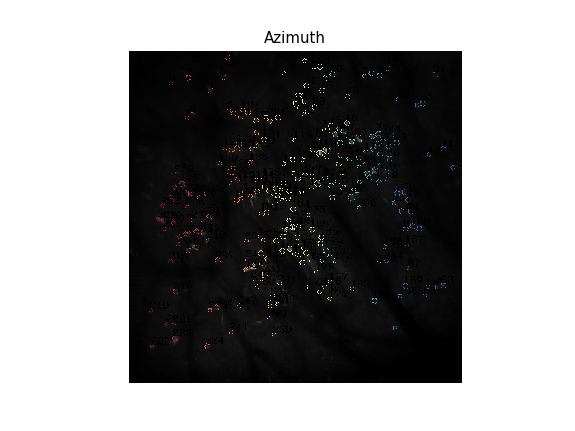

In [579]:
### plot and color-code by position to check sorting:

# fig, ax = pl.subplots()
# util.plot_roi_contours(zimg, roi_contours_ixs, sorted_roi_contours, clip_limit=0.008, label=True, 
#                           draw_box=False, thickness=1, roi_color=(255, 255, 255), single_color=False, ax=ax)

#### Plot spatially sorted ROIs

<IPython.core.display.Javascript object>


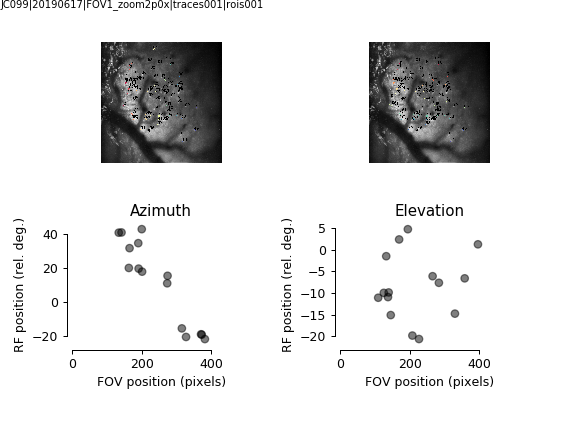

In [123]:
fig, axes = pl.subplots(2,2)
fig.patch.set_alpha(1)

ax = axes[0,0]
util.plot_roi_contours(zimg,[c[0] for c in sort_x], [c[1] for c in sort_x], clip_limit=0.008, label=True, 
                           draw_box=False, thickness=1, roi_color=(255, 255, 255), single_color=False, ax=ax)
ax.axis('off')
                    
ax = axes[0,1]
util.plot_roi_contours(zimg,[c[0] for c in sort_x], [c[1] for c in sort_y], clip_limit=0.008, label=True, 
                           draw_box=False, thickness=1, roi_color=(255, 255, 255), single_color=False, ax=ax)
ax.axis('off')

    
rf_rois = rf_fits_df.index.tolist() 
colors = ['k' for roi in rf_rois]

# Get values for azimuth:
spatial_rank_x = [rois_sort_xaxis.index(roi) for roi in rf_rois] # Get sorted rank for indexing
pixel_order_x = [sort_x_centroids[s] for s in spatial_rank_x]    # Get corresponding spatial position in FOV
pixel_order_xvals = [p[0] for p in pixel_order_x]
rf_xpos = [rf_fits_df.loc[roi]['x0'] for roi in rf_rois]

# Get values for elevation
spatial_rank_y = [rois_sort_yaxis.index(roi) for roi in rf_rois] # Get sorted rank for indexing
pixel_order_y = [sort_y_centroids[s] for s in spatial_rank_y]    # Get corresponding spatial position in FOV
pixel_order_yvals = [p[1] for p in pixel_order_y]
rf_ypos = [rf_fits_df.loc[roi]['y0'] for roi in rf_rois]

ax = axes[1,0]
ax.scatter(pixel_order_yvals, rf_xpos, c=colors, alpha=0.5)
ax.set_title('Azimuth')
ax.set_ylabel('RF position (rel. deg.)')
ax.set_xlabel('FOV position (pixels)')
ax.set_xlim([0, 512])
sns.despine(offset=4, trim=True, ax=ax)

ax = axes[1,1]
ax.scatter(pixel_order_xvals, rf_ypos, c=colors, alpha=0.5)
ax.set_title('Elevation')
ax.set_ylabel('RF position (rel. deg.)')
ax.set_xlabel('FOV position (pixels)')
ax.set_xlim([0, 512])
ax.axis('on')
# #ax.set_aspect('auto')
sns.despine(offset=4, trim=True, ax=ax)

pl.subplots_adjust(wspace=0.5, top=0.9, hspace=0.5, bottom=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(output_dir, 'spatially_sorted_rois_%s.png' % rf_exp_name))

#### Calculate RF sizes/overlap with stimuli

In [124]:
gratings_color = 'orange'
blobs_color = 'blue'
colordict = {'gratings': gratings_color,
            'blobs-min': blobs_color,
            'blobs-max': blobs_color}


## create GRATINGS patch
s_gratings = create_ellipse((xpos, ypos), (gratings_sz/2., gratings_sz/2.), 0)
v_gratings = np.array(s_gratings.exterior.coords.xy)

## create BLOBS patch(es) - min/max
ry_min = ypos - blobs_sz_min/2.
rx_min = xpos - blobs_sz_min/2.
ry_max = ypos + blobs_sz_min/2.
rx_max = xpos + blobs_sz_min/2.
s_blobs_min = box(rx_min, ry_min, rx_max, ry_max)
v_blobs_min = np.array(s_blobs_min.exterior.coords.xy)

ry_min = ypos - blobs_sz_max/2.
rx_min = xpos - blobs_sz_max/2.
ry_max = ypos + blobs_sz_max/2.
rx_max = xpos + blobs_sz_max/2.
s_blobs_max = box(rx_min, ry_min, rx_max, ry_max)
v_blobs_max = np.array(s_blobs_max.exterior.coords.xy)


<IPython.core.display.Javascript object>


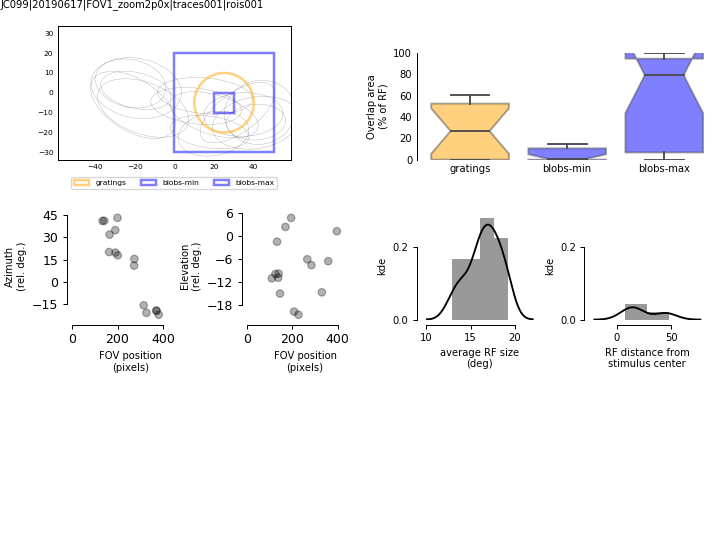

Bbox(x0=0.1, y0=0.7025, x1=0.504545454545, y1=0.9)


In [125]:

# PLOT
fig = pl.figure(figsize=(8,6))
fig.patch.set_alpha(1)

# Screen visualization ----------------------------------------------------
ax0 = pl.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=1)
ax0.set_xlim([screen_bounds[1], screen_bounds[3]])
ax0.set_ylim([screen_bounds[0], screen_bounds[2]])
ax0.set_aspect(screen_aspect)
ax0.tick_params(axis='both', which='both', length=0, labelsize=6)


# Draw receptive fields, calculate overlap(s):
in_gratings = []
in_blobs_min = []
in_blobs_max = []
rf_dist_from_center = []
rf_avg_size = []
for roi in sorted(roi_lists[rf_exp_name]):
    sx, sy, th, x0, y0 = rf_fits_df.loc[roi]
    s_ell = create_ellipse((x0, y0), (abs(sx)*sigma_scale/2., abs(sy)*sigma_scale/2.), np.rad2deg(th))
    v_ell = np.array(s_ell.exterior.coords.xy)
    p_ell = Polygon(v_ell.T, edgecolor='k', alpha=0.5, facecolor='none', lw=0.2)
    ax0.add_patch(p_ell)
    
    ## get intersection and compute areas/ratios:
    intersect_wgratings = s_ell.intersection(s_gratings)
    intersect_wblobs_min = s_ell.intersection(s_blobs_min)
    intersect_wblobs_max = s_ell.intersection(s_blobs_max)
    
    in_gratings.append(intersect_wgratings.area / s_ell.area)
    in_blobs_min.append(intersect_wblobs_min.area / s_ell.area)
    in_blobs_max.append(intersect_wblobs_max.area / s_ell.area)
    
    ## get distance bw RF centers and stimulus location:
    rf_dist_from_center.append(np.sqrt((x0 - xpos)**2 + (y0 - ypos)**2))
    rf_avg_size.append(np.mean([abs(sx)*sigma_scale/2., abs(sy)*sigma_scale/2.]))
    

# Draw patches:
p_gratings = Polygon(v_gratings.T, edgecolor=gratings_color, alpha=0.5, lw=2, facecolor='none', label='gratings')
ax0.add_patch(p_gratings)
p_blobs_min = Polygon(v_blobs_min.T, edgecolor=blobs_color, alpha=0.5, lw=2, facecolor='none', label='blobs-min')
ax0.add_patch(p_blobs_min)
p_blobs_max = Polygon(v_blobs_max.T, edgecolor=blobs_color, alpha=0.5, lw=2, facecolor='none', label='blobs-max')
ax0.add_patch(p_blobs_max)


# ---- Proportion of RF overlapping with stimulus bounds ----
all_overlap_values = copy.copy(in_gratings)
stimulus_labels = ['gratings' for _ in range(len(in_gratings))]
all_overlap_values.extend(in_blobs_min)
stimulus_labels.extend(['blobs-min' for _ in range(len(in_blobs_min))])
all_overlap_values.extend(in_blobs_max)
stimulus_labels.extend(['blobs-max' for _ in range(len(in_blobs_max))])
stimulus_colors = [colordict[e] for e in stimulus_labels]

overlap_df = pd.DataFrame({'stimulus': stimulus_labels,
                          'overlap': np.array(all_overlap_values)*100.,
                          'color': stimulus_colors})

ax = pl.subplot2grid((3, 4), (0, 2), colspan=2, rowspan=1)
ax = sns.boxplot(x="stimulus", y="overlap", data=overlap_df, ax=ax, 
                 palette=colordict, saturation=1.0, notch=True, boxprops=dict(alpha=.5))
ax.set_xlabel('')
ax.set_ylabel('Overlap area\n(% of RF)', fontsize=8)
ax.set_ylim([0, 100])
ax.tick_params(axis='x', which='both', length=0, labelsize=8)
ax.tick_params(axis='y', which='both', length=0, labelsize=8)

sns.despine(trim=True, offset=4, ax=ax, bottom=True)



# ---- Average RF size -----------------------
ax2a = pl.subplot2grid((3, 4), (1, 2), colspan=1, rowspan=1)
sns.distplot(rf_avg_size, ax=ax2a, color='k')
ax2a.set_xlabel('average RF size\n(deg)', fontsize=8)
ax2a.set_ylabel('kde', fontsize=8)
ax2a.tick_params(axis='both', which='both', length=3, labelsize=8)
ax2a.yaxis.set_major_locator(MaxNLocator(2))
ax2a.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
sns.despine(trim=True, offset=4, ax=ax2a)

# ---- Distance from stimulus center -----------------------
ax2b = pl.subplot2grid((3, 4), (1, 3), colspan=1, rowspan=1)
sns.distplot(rf_dist_from_center, ax=ax2b, color='k')
ax2b.set_xlabel('RF distance from\nstimulus center', fontsize=8)
ax2b.set_ylabel('kde', fontsize=8)
ax2b.tick_params(axis='both', which='both', length=3, labelsize=8)
ymax = max([ax2a.get_ylim()[-1], ax2b.get_ylim()[-1]])
ax2b.set_ylim([0, ymax])
ax2b.yaxis.set_major_locator(MaxNLocator(2))
ax2b.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
sns.despine(trim=True, offset=4, ax=ax2b)


# ---- Spatially sorted ROIs vs. RF position -----------------------
rf_rois = rf_fits_df.index.tolist() 
colors = ['k' for _ in range(len(rf_rois))]

# Get values for azimuth:
spatial_rank_x = [rois_sort_xaxis.index(roi) for roi in rf_rois] # Get sorted rank for indexing
pixel_order_x = [sort_x_centroids[s] for s in spatial_rank_x]    # Get corresponding spatial position in FOV
pixel_order_xvals = [p[0] for p in pixel_order_x]
rf_xpos = [rf_fits_df.loc[roi]['x0'] for roi in rf_rois]

# Get values for elevation
spatial_rank_y = [rois_sort_yaxis.index(roi) for roi in rf_rois] # Get sorted rank for indexing
pixel_order_y = [sort_y_centroids[s] for s in spatial_rank_y]    # Get corresponding spatial position in FOV
pixel_order_yvals = [p[1] for p in pixel_order_y]
rf_ypos = [rf_fits_df.loc[roi]['y0'] for roi in rf_rois]

ax3a = pl.subplot2grid((3, 4), (1, 0), colspan=1, rowspan=1)
ax3a.scatter(pixel_order_yvals, rf_xpos, c=colors, alpha=0.3) # FOV y-axis is left-right on brain
#ax3a.set_title('Azimuth', fontsize=8)
ax3a.set_ylabel('Azimuth\n(rel. deg.)', fontsize=8)
ax3a.set_xlabel('FOV position\n(pixels)', fontsize=8)
ax3a.set_xlim([0, 512])
ax3a.yaxis.set_major_locator(MaxNLocator(5))
sns.despine(trim=True, offset=4, ax=ax3a)

ax3b = pl.subplot2grid((3, 4), (1, 1), colspan=1, rowspan=1)
ax3b.scatter(pixel_order_xvals, rf_ypos, c=colors, alpha=0.3) # FOV x-axis is posterior-anterior on brain
ax3b.set_ylabel('Elevation\n(rel. deg.)', fontsize=8)
ax3b.set_xlabel('FOV position\n(pixels)', fontsize=8)
ax3b.set_xlim([0, 512])
#ax.set_aspect('auto')
ax3b.yaxis.set_major_locator(MaxNLocator(5))
sns.despine(trim=True, offset=4, ax=ax3b)


pl.subplots_adjust(left=0.1, top=0.9, right=0.99, wspace=0.5, hspace=0.5)


bbox_s = ax2b.get_position()
bbox_s2 = [bbox_s.x0 - 0.01, bbox_s.y0,  bbox_s.width, bbox_s.height] 
ax2b.set_position(bbox_s2) # set a new position

# Move upper-left plot over to reduce white space
bbox = ax0.get_position()
print(bbox)
bbox2 = [bbox.x0 - 0.04, bbox.y0+0.0,  bbox.width-0.04, bbox.height+0.05] 
ax0.set_position(bbox2) # set a new position
ax0.legend(fontsize=6, ncol=3, loc='lower center', bbox_to_anchor=[0.5, -0.25])

label_figure(fig, data_identifier)

pl.savefig(os.path.join(output_dir, 'visual_field_coverage_w%s.png' % rf_exp_name))

# Stimuli and resize to compare against RFs

In [126]:
def resize_image_to_coords(im, size_deg=30, pix_per_deg=10.01, aspect_scale=1.747):
    print(pix_per_deg)
    ref_dim = max(im.shape)
    resize_factor = ((size_deg*pix_per_deg) / ref_dim ) / pix_per_deg
    scale_factor = resize_factor * aspect_scale
    
    imr = cv2.resize(im, None, fx=scale_factor, fy=scale_factor)
    
    return imr


In [127]:
S.screen

{'aspect': 0.5726770694395296,
 'azimuth': 'right',
 'bounding_box': [None, None, None, None],
 'elevation': 'top',
 'height': 67.323,
 'linmaxH': 33.661499999999997,
 'linmaxW': 58.779200000000003,
 'linminH': -33.661499999999997,
 'linminW': -58.779200000000003,
 'resolution': [1024, 768],
 'width': 117.5584}

In [128]:
# Get image paths:
stimulus_dir = '/home/julianarhee/Repositories/protocols/physiology/stimuli/images'
#object_list = ['D1', 'M14', 'M27', 'M53', 'M66', 'M9', 'M93', 'D2']
object_list = ['D1', 'D2']
image_paths = []
for obj in object_list:
    stimulus_type = 'Blob_%s_Rot_y_fine' % obj
    image_paths.extend(glob.glob(os.path.join(stimulus_dir, stimulus_type, '*_y0.png')))
print("%i images found for %i objects" % (len(image_paths), len(object_list)))

images = {}
for object_name, impath in zip(object_list, image_paths):
    im = cv2.imread(impath)
    images[object_name] = im[:, :, 0]
print("im shape:", images['D1'].shape)


screen_width_deg = 59.7782*2.  #S.screen['linmaxW']*2
screen_height_deg = 33.6615*2. #S.screen['linmaxH']*2

pix_per_degW = S.screen['resolution'][0] / screen_width_deg
pix_per_degH = S.screen['resolution'][1] / screen_height_deg 

print(pix_per_degW, pix_per_degH)
pix_per_deg = np.mean([pix_per_degW, pix_per_degH])
print("avg pix/deg: %.2f" % pix_per_deg)


2 images found for 2 objects
('im shape:', (618, 1080))
(8.564995265832696, 11.407691279354754)
avg pix/deg: 9.99


In [129]:
pix_per_degW

8.564995265832696

<IPython.core.display.Javascript object>


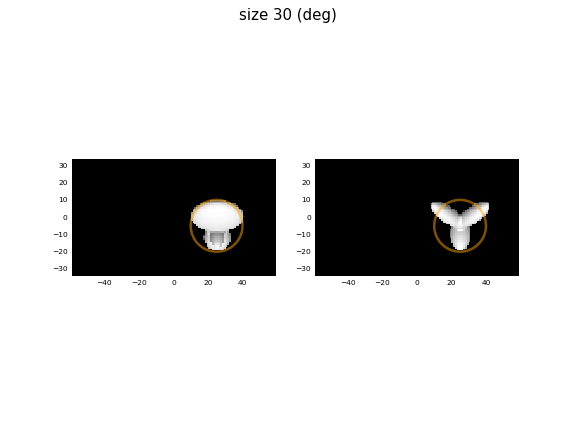

8.56499526583
8.56499526583


In [130]:
size_deg = 30
pix_per_deg = pix_per_degW

# PLOT
fig, axes = pl.subplots(1,2) #pl.figure(figsize=(8,6))
fig.patch.set_alpha(1)
fig.suptitle('size %i (deg)' % size_deg)

# Screen visualization ----------------------------------------------------
#ax0 = pl.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=1)
ax = axes[0]
ax.set_facecolor('k')
ax.set_xlim([screen_bounds[1], screen_bounds[3]])
ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

imr = resize_image_to_coords(images['D1'], size_deg=size_deg, pix_per_deg=pix_per_deg)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
ax.imshow(imr, cmap='gray', extent=extent)


## create GRATINGS patch
s_gratings = create_ellipse((xpos, ypos), (size_deg/2., size_deg/2.), 0)
v_gratings = np.array(s_gratings.exterior.coords.xy)
# Draw patches:
p_gratings = Polygon(v_gratings.T, edgecolor=gratings_color, alpha=0.5, lw=2, facecolor='none', label='gratings')
ax.add_patch(p_gratings)



#ax0 = pl.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=1)
ax = axes[1]
ax.set_facecolor('k')

ax.set_xlim([screen_bounds[1], screen_bounds[3]])
ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

imr = resize_image_to_coords(images['D2'], size_deg=size_deg, pix_per_deg=pix_per_deg)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
ax.imshow(imr, cmap='gray', extent=extent)

## create GRATINGS patch
# s_gratings = create_ellipse((xpos, ypos), (gratings_sz/2., gratings_sz/2.), 0)
# v_gratings = np.array(s_gratings.exterior.coords.xy)
# Draw patches:
p_gratings = Polygon(v_gratings.T, edgecolor=gratings_color, alpha=0.5, lw=2, facecolor='none', label='gratings')
ax.add_patch(p_gratings)



# Linear SVM

In [131]:
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, colorbar


In [132]:
def plot_coefficients(classifier, feature_names, top_features=20, colors=None, ax=None):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    if ax is None:
        fig, ax = pl.subplots(figsize=(10,4))
    if colors is None:
        colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    ax.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    ax.set_xticks(np.arange(1, 1 + 2 * top_features))
    ax.set_xticklabels(feature_names[top_coefficients], rotation=60, ha='right')
    
    top_pos_features = feature_names[top_positive_coefficients]
    top_neg_features = feature_names[top_negative_coefficients]
    return top_positive_coefficients, top_negative_coefficients, ax


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=pl.cm.Blues, ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    if ax is None:
        fig, ax = pl.subplots()
        
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

In [133]:
# create output dir for SVM results:
svm_output_dir = os.path.join(output_dir, 'linearSVM')
if not os.path.exists(svm_output_dir):
    os.makedirs(svm_output_dir)

In [134]:
gdf = exp_gdfs['blobs'] # exp_gdfs use trace_type = 'dff'

In [135]:
sample_data = pd.concat([pd.DataFrame(roidf['meanstim'].values, columns=[roi],
                                          index=roidf['config']) for roi, roidf in gdf], axis=1)
sample_labels = np.array(sample_data.index.tolist())
sample_data = sample_data.reset_index(drop=True)

In [136]:
sample_data.head()

,8,19,29,32,33,49,69,92,96
0,0.255153,0.150890,0.288278,0.149213,0.234052,0.180490,0.374447,0.134687,0.302621
1,0.307328,0.191341,0.318163,0.203837,0.194810,0.190209,0.291857,0.168495,0.347319
2,0.392308,0.286663,0.341438,0.221902,0.210219,0.289575,0.208600,0.114897,0.424155
3,0.295897,0.275151,0.242940,0.335116,0.223155,0.392023,0.233895,0.170794,0.459307
4,0.235588,0.259832,0.253464,0.188480,0.232483,0.204284,0.268895,0.110982,0.414223


In [137]:
sdf = S.experiments['blobs'].data.sdf.copy()
# Exclude non-morph controls for now:
sdf = sdf[sdf['morphlevel']!=-1] # get rid of controls for now
tested_sizes = sorted(sdf ['size'].unique())
tested_morphs = sorted(sdf ['morphlevel'].unique())
print('sizes:', tested_sizes)
print('morphs:', tested_morphs)


('sizes:', [10.0, 20.0, 30.0, 40.0, 50.0])
('morphs:', [0, 14, 27, 40, 53, 66, 79, 92, 106])


In [138]:
#% Specify train/test conditions:     
class_name = 'morphlevel'
class_types = [0, 106]
restrict_transform = True
constant_transform = 'size'

C = 1e3
m0 = 0
m100 = 106
#fig, ax = pl.subplots()


size_colors = sns.cubehelix_palette(len(tested_sizes))
lw=2


In [139]:
curr_sz = 30
restrict_transform = True

In [140]:
sample_data.head()

,8,19,29,32,33,49,69,92,96
0,0.255153,0.150890,0.288278,0.149213,0.234052,0.180490,0.374447,0.134687,0.302621
1,0.307328,0.191341,0.318163,0.203837,0.194810,0.190209,0.291857,0.168495,0.347319
2,0.392308,0.286663,0.341438,0.221902,0.210219,0.289575,0.208600,0.114897,0.424155
3,0.295897,0.275151,0.242940,0.335116,0.223155,0.392023,0.233895,0.170794,0.459307
4,0.235588,0.259832,0.253464,0.188480,0.232483,0.204284,0.268895,0.110982,0.414223


In [141]:
# SElect all responsive blobs that we have RFs for:

rfs_in_blobs = [r for r in roi_lists['blobs'] if r in roi_lists[rf_exp_name]]


In [142]:
if restrict_transform:
    constant_transform_val = curr_sz
    train_configs = sdf[((sdf[class_name].isin(class_types)) & (sdf[constant_transform]==constant_transform_val))].index.tolist()
    transform_str = '%s%i' % (constant_transform, curr_sz)
else:
    train_configs = sdf[sdf[class_name].isin(class_types)].index.tolist()
    transform_str = 'xtransforms'
print train_configs


# Set train/test set:
train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

X = sample_data[rfs_in_blobs].iloc[train_ixs].reset_index(drop=True) #[train_configs]
y = np.array([sdf[class_name][c] for c in sample_labels[train_ixs]])
print X.shape
print y.shape

# # Set validation set:
# untrained_class_types = [c for c in sdf[class_name].unique() if c not in class_types]
# test_configs = sdf[( (sdf[constant_transform]==constant_transform_val) & (sdf[class_name].isin(untrained_class_types)) )].index.tolist()
# test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
# X_test = sample_data.iloc[test_ixs].values
# y_test_labels = sample_labels[test_ixs]



['config008', 'config048']
(38, 3)
(38,)


In [176]:
train, validate, test = np.split(X.sample(frac=1), [int(.6*len(X)), int(.8*len(X))])
print("train:", train.shape)
print("validation:", validate.shape)
print("test:", test.shape)

train_labels = y[np.array(train.index.tolist())]
validate_labels = y[np.array(validate.index.tolist())]
test_labels = y[np.array(test.index.tolist())]


#### Fit & test

scaler = preprocessing.StandardScaler().fit(train)
train_transformed = scaler.transform(train)

# Fit SVM:
trained_svc = LinearSVC(multi_class='ovr', C=C).fit(train_transformed, train_labels)

# Validate:
validate_transformed = scaler.transform(validate)
validate_score = trained_svc.score(validate_transformed, validate_labels)  
validate_predictions = trained_svc.predict(validate_transformed)

# Test:
test_transformed = scaler.transform(test)
test_score = trained_svc.score(test_transformed, test_labels)  
test_predictions = trained_svc.predict(test_transformed)

print("VALIDATE score: %.2f " % (validate_score))
print("TEST score: %.2f " % (test_score))

('train:', (22, 3))
('validation:', (8, 3))
('test:', (8, 3))
VALIDATE score: 0.62 
TEST score: 0.62 


In [177]:
def show_linearSVC_class_separation(linearSVC, X_test, y_test):

    y_decision_score = linearSVC.decision_function(X_test)

    # getting the score of the truly positive individuals
    y_positive_decision_score = y_decision_score[y_test == 1]

    # getting the score of the truly negative individuals
    y_negative_decision_score = y_decision_score[y_test == 0]

    # get the (min-1) and the (max +1) scores to be sure to include all the scores in the intervals of the histogramme
    _, min_positive = np.modf(y_positive_decision_score.min() - 1)
    _, max_positive = np.modf(y_positive_decision_score.max() + 1)
    positive_bins = np.arange(min_positive, max_positive + 1)

    # get the (min-1) and the (max +1) scores to be sure to include all the scores in the intervals of the histogramme    
    _, min_negative = np.modf(y_negative_decision_score.min() - 1)
    _, max_negative = np.modf(y_negative_decision_score.max() + 1)
    negative_bins = np.arange(min_negative, max_negative + 1)

    # plot the two histograms, alpha (the transparency) is for the overlapping areas
    pl.hist(y_positive_decision_score, bins=positive_bins, alpha=0.5, label='True positives', color='r')
    pl.hist(y_negative_decision_score, bins=negative_bins, alpha=0.5, label='True negatives', color='b')

    pl.xlabel('SVM decision_function values')
    pl.ylabel('Number of data points')
    pl.show()

# pl.figure()
# y_test = np.array([1 if v==106 else 0 for v in test_labels])

# show_linearSVC_class_separation(trained_svc, test_transformed, y_test)

### Plot top features and RFs overlaid w/ stimulus

In [178]:
trained_svc.classes_[1]

106

<IPython.core.display.Javascript object>


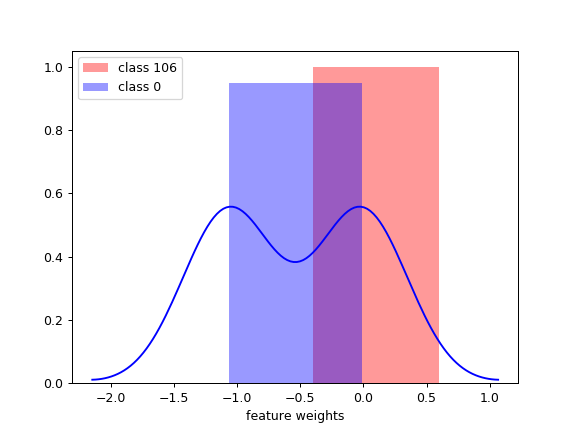

In [179]:
pl.figure()
feature_weights = np.array(trained_svc.coef_.ravel())
sns.distplot(feature_weights[feature_weights>0], color='r', label='class %i' % trained_svc.classes_[1])
sns.distplot(feature_weights[feature_weights<0], color='b', label='class %i' % trained_svc.classes_[0])
pl.legend()
pl.xlabel('feature weights')
pl.savefig(os.path.join(svm_output_dir, '%s_distN_feature_weights_by_class_%s.png' % (rf_exp_name, transform_str) ))

<IPython.core.display.Javascript object>


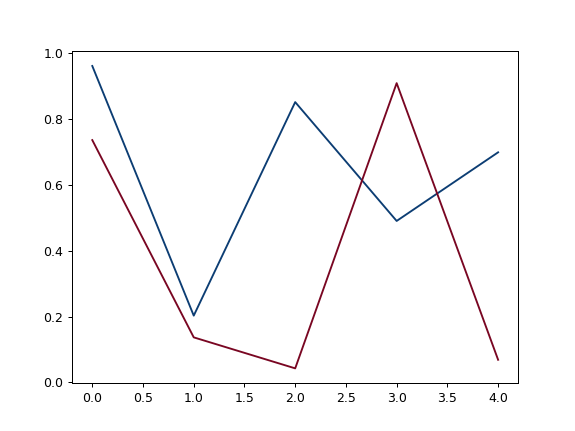

In [408]:
pl.figure()
pl.plot(np.random.random(5), color=weight_colors[0])
pl.plot(np.random.random(5), color=weight_colors[-1])


In [180]:
from matplotlib.lines import Line2D


In [184]:
train.shape

(22, 3)

In [185]:
marker_style = 'centroids'
plot_top_n=-1

fig = pl.figure(figsize=(8, 6)) # = pl.subplots(2,1)
fig.patch.set_alpha(1)

### Plot sorted feature weights:
ax0 = pl.subplot2grid((5, 3), (0, 0), colspan=2, rowspan=1)
n_top_features=max([20, int(np.floor(len(train.columns.tolist())/2.))])
weight_colors = sns.color_palette('RdBu_r', n_top_features*2)
feature_names = np.array(train.columns.tolist())
top_pos_ixs, top_neg_ixs, ax = plot_coefficients(trained_svc, feature_names, ax=ax0,
                                                 top_features=n_top_features, colors=weight_colors)
top_pos = feature_names[top_pos_ixs]
top_neg = feature_names[top_neg_ixs]
sorted_feature_ixs = np.argsort(trained_svc.coef_.ravel())

sns.despine(offset=2, ax=ax0)
ax0.set_xlabel('sorted features (top %i)' % n_top_features)
ax0.set_ylabel('weights')
ax0.set_xticks([])
ax0.tick_params(axis='both', which='both', length=3, labelsize=8, rotation=0)

# create legend to show which object is red/blue:
custom_lines = [Line2D([0], [0], color=weight_colors[0], lw=2),
                Line2D([0], [0], color=weight_colors[-1], lw=2)]
ax.legend(custom_lines, [trained_svc.classes_[0], trained_svc.classes_[1]], fontsize=6, loc='upper left')

# Create color map from sorted weights:
if plot_top_n == -1:
    top_coef_cells = feature_names[sorted_feature_ixs]
    matched_rois = copy.copy(feature_names)
else:
    top_coef_cells = np.hstack([top_neg, top_pos]) # Colors go from Blue -- > Red (weights go from NEG --> POS)

    # Get receptive fields:
    matched_rois = [r for r in rf_fits_df.index.tolist() if r in top_pos[-plot_top_n:] or r in top_neg[0:plot_top_n]]

weight_colors = sns.color_palette('RdBu_r', len(top_coef_cells))


# Screen visualization ----------------------------------------------------
ax = pl.subplot2grid((5, 3), (1, 0), colspan=2, rowspan=3)
ax.set_facecolor('k')
ax.set_xlim([screen_bounds[1], screen_bounds[3]])
ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

# Draw stimulus diff image:
diff_img = images['D1']-images['D2']
imr = resize_image_to_coords(diff_img, size_deg=curr_sz, pix_per_deg=pix_per_degW)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
im0 = ax.imshow(diff_img, cmap='gray', extent=extent)

## plot RFs -----------------------------------------------
print(len(matched_rois))
for roi in matched_rois:  
    roi_color = weight_colors[list(top_coef_cells).index(roi)]

    sx, sy, th, x0, y0 = rf_fits_df.loc[roi]
    if marker_style == 'weights':
        feature_weight = trained_svc.coef_.ravel()[train.columns.tolist().index(roi)]
        ax.plot(x0, y0, color=roi_color, marker='o', markersize=np.abs(feature_weight)*100., \
                markerfacecolor='none', markeredgecolor=roi_color, alpha=1)

    elif marker_style == 'centroids':
        ax.plot(x0, y0, color=roi_color, marker='+', markersize=5, \
                markerfacecolor=roi_color, markeredgecolor=roi_color, alpha=1)
        
    elif marker_style == 'rfs':
        s_ell = create_ellipse((x0, y0), (abs(sx)*sigma_scale/2., abs(sy)*sigma_scale/2.), np.rad2deg(th))
        v_ell = np.array(s_ell.exterior.coords.xy)
        p_ell = Polygon(v_ell.T, edgecolor=roi_color, alpha=1, facecolor='none', lw=1)
        ax.add_patch(p_ell)

## 
ax1 = pl.subplot2grid((5, 3), (0, 2), colspan=1, rowspan=1)
plot_confusion_matrix(validate_labels, validate_predictions, classes=class_types, normalize=True,
                      title='Validation', ax=ax1)

ax2 = pl.subplot2grid((5, 3), (2, 2), colspan=1, rowspan=1)
plot_confusion_matrix(test_labels, test_predictions, classes=class_types, normalize=True,
                      title='Test', ax=ax2)

    
pl.subplots_adjust(hspace=0.1, wspace=0.5, left=0.1)
fig.suptitle('size %i' % curr_sz)


label_figure(fig, data_identifier)




pl.savefig(os.path.join(svm_output_dir, '%s_rois_decodeAB_%s_plot_%s_colorweights_top%i.png' % (rf_exp_name, transform_str, marker_style, plot_top_n)))



<IPython.core.display.Javascript object>

ValueError: shape mismatch: objects cannot be broadcast to a single shape

# Plot all RF positions relative to the difference image 

In [186]:
# Get all blob-responsive cells that there are RF fits for:
print len(rfs_in_blobs)

3


In [187]:
len(feature_weights)

3

<IPython.core.display.Javascript object>


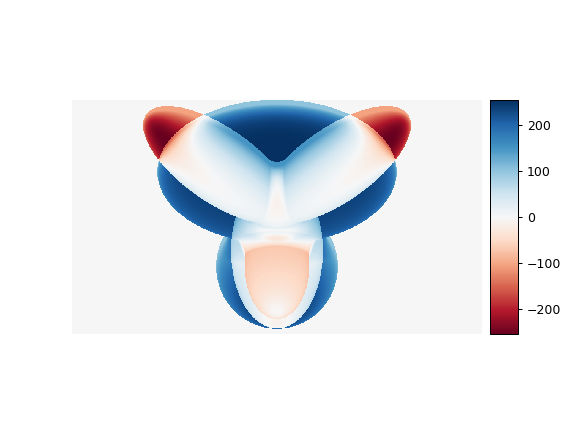

In [188]:
fig, axes = pl.subplots(1, 1)
fig.patch.set_alpha(1)
diff_img = images['D1'].astype('float') - images['D2'].astype(float)

ax=axes#thresh_ma[np.isnan(thresh_ma)] = 0
#thresh_ma[thresh_ma>0] = 1
im1 = ax.imshow(diff_img, cmap='RdBu')
ax1_divider = make_axes_locatable(ax)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = pl.colorbar(im1, cax=cax1, orientation="vertical")
ax.axis('off')

# ax = axes[1]
# im2 = ax.imshow(thresh_ma - images['D2'], cmap='Reds')
# ax2_divider = make_axes_locatable(ax)
# cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
# cb2 = colorbar(im2, cax=cax2, orientation="vertical")
# ax.axis('off')

pl.subplots_adjust(wspace=0.5)

pl.savefig(os.path.join(svm_output_dir, 'difference_images_highlight.png'))

#### Create a difference image

In [189]:
from skimage.measure import compare_ssim


<IPython.core.display.Javascript object>


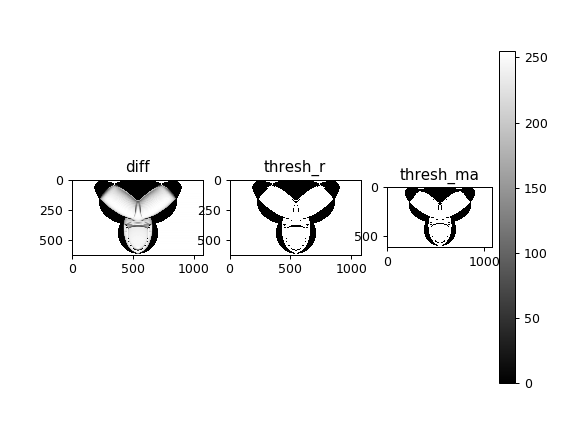

('Image similarity', 0.77914943351192989)
(255, 0)


In [190]:
fig, ax = pl.subplots(1,3)
# Draw stimulus diff image:
diff_img = images['D1']-images['D2']

(score, diff) = compare_ssim(images['D1'], images['D2'], full=True)
print("Image similarity", score)
# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type in the range [0,1] 
diff = (diff * 255).astype("uint8")

# threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]


#thresh_ma = np.ma.array(thresh, mask=thresh==0) # high values = most similar, low values = least similar
print(thresh.max(), thresh.min())


im = ax[0].imshow(diff, cmap='gray') # thresh: 255 = most different, 0 = most similar
ax[0].set_title('diff')

thresh_rev = 255 - thresh
im = ax[1].imshow(thresh_rev, cmap='gray') # thresh: 255 = most different, 0 = most similar
ax[1].set_title('thresh_r')


thresh_ma = np.ma.array(thresh_rev.copy(), mask=thresh_rev==255)# high values = most similar, low values = least similar
ax[2].imshow(thresh_ma, cmap='gray')
ax[2].set_title('thresh_ma')

pl.colorbar(im)


In [147]:
from mpl_toolkits.axes_grid1.colorbar import colorbar


<IPython.core.display.Javascript object>


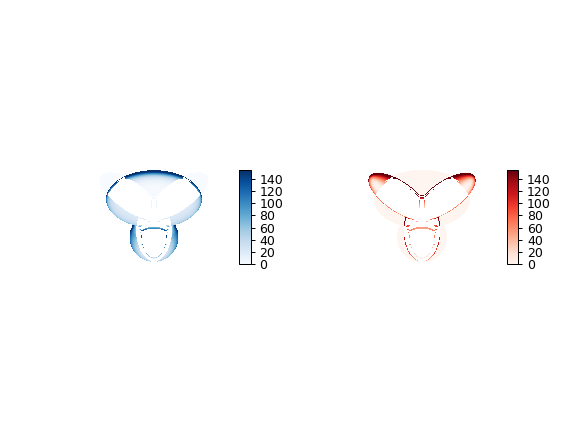

In [191]:
fig, axes = pl.subplots(1, 2)
fig.patch.set_alpha(1)

ax=axes[0]#thresh_ma[np.isnan(thresh_ma)] = 0
#thresh_ma[thresh_ma>0] = 1
im1 = ax.imshow( thresh_ma - (images['D1']), cmap='Blues')
ax1_divider = make_axes_locatable(ax)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = pl.colorbar(im1, cax=cax1, orientation="vertical")
ax.axis('off')

ax = axes[1]
im2 = ax.imshow(thresh_ma - images['D2'], cmap='Reds')
ax2_divider = make_axes_locatable(ax)
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
cb2 = pl.colorbar(im2, cax=cax2, orientation="vertical")
ax.axis('off')

pl.subplots_adjust(wspace=0.5)

pl.savefig(os.path.join(svm_output_dir, 'difference_images_highlight2.png'))

#### Create a density map of RFs

In [192]:
import statsmodels as sm


In [193]:
feature_weights

array([-1.06788905,  0.09983316, -0.01398725])

In [194]:
from pipeline.python.classifications import kde_2d_weighted as kd

In [195]:
def get_2d_kde(xvals, yvals, bounds=None, weights=None, xres=200, yres=200):
    xy = np.vstack([xvals, yvals])
    #xmin, xmax = (xy[0].min(), xy[0].max())
    #ymin, ymax = (xy[1].min(), xy[1].max())
    if bounds is None:
        xmin, xmax = (xvals.min(), xvals.max())
        ymin, ymax = (yvals.min(), yvals.max())
    else:
        [ymin, xmin, ymax, xmax] = bounds
        
    # Peform the kernel density estimate
    x = np.linspace(xmin, xmax, xres)  # kde resolution
    y = np.linspace(ymin, ymax, yres)  # kde resolution
    xx, yy = np.meshgrid(x, y)

    # weighted KDE
    pdf = kd.gaussian_kde(xy, weights=np.array(np.abs(weights), np.float))
    pdf.set_bandwidth(bw_method=pdf.factor / 2.)  # kde bandwidth (bigger, more smooth)
    zz2 = pdf((np.ravel(xx), np.ravel(yy)))
    zz2 = np.reshape(zz2, xx.shape)
    
    return zz2


In [196]:
d1, d2 = images['D1'].shape

xvals = np.array([rf_fits_df['x0'][roi] for ri, roi in enumerate(feature_names) if feature_weights[ri]<0])
yvals = np.array([rf_fits_df['y0'][roi] for ri, roi in enumerate(feature_names) if feature_weights[ri]<0])
weights = [f for f in feature_weights if f < 0]
zz_neg = get_2d_kde(xvals, yvals, bounds=screen_bounds, weights=weights, xres=d2, yres=d1)
obs_neg = np.vstack([xvals, yvals]).T

xvals = np.array([rf_fits_df['x0'][roi] for ri, roi in enumerate(feature_names) if feature_weights[ri]>0])
yvals = np.array([rf_fits_df['y0'][roi] for ri, roi in enumerate(feature_names) if feature_weights[ri]>0])
weights = [f for f in feature_weights if f > 0]
zz_pos = get_2d_kde(xvals, yvals, bounds=screen_bounds, weights=weights, xres=d2, yres=d1)
obs_pos = np.vstack([xvals, yvals]).T

# Mask to clear empty space:
zz_neg_ma = np.ma.array(zz_neg, mask=zz_neg<=0.003)
zz_pos_ma = np.ma.array(zz_pos, mask=zz_pos<=0.003)



/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/kde_2d_weighted.py:196: RuntimeWarning: invalid value encountered in divide
  result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor
/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/kde_2d_weighted.py:286: RuntimeWarning: invalid value encountered in divide
  self._data_covariance /= (1 - np.sum(self.weights ** 2))
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal


In [197]:
svm_output_dir

'/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/summaries/linearSVM'

In [198]:
fig, ax = pl.subplots(figsize=(10,10))

fig.patch.set_alpha(1)

zoom=20
ax.set_xlim([xpos-zoom, xpos+zoom])
ax.set_ylim([ypos-zoom, ypos+zoom])


# Draw stimulus diff image:
diff_img = images['D1'].astype('float') - images['D2'].astype(float)
#(score, grad, diff) = compare_ssim(images['D1'], images['D2'], full=True, gradient=True)
imr = resize_image_to_coords(diff_img, size_deg=curr_sz, pix_per_deg=pix_per_degW)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
im0 = ax.imshow(diff, cmap='gray', extent=extent) #vmin=0, vmax=0.9)


bounds = [screen_bounds[1], screen_bounds[3], screen_bounds[0], screen_bounds[2]]
im1 = ax.imshow(np.flipud(zz_neg_ma), extent=bounds, cmap='Blues', alpha=0.5)
cba = pl.colorbar(im1,shrink=0.25)
cba.ax.set_title('class %i' % trained_svc.classes_[0], fontsize=6)


im2 = ax.imshow(np.flipud(zz_pos_ma), extent=bounds, cmap='Reds', alpha=0.5)
# ax2_divider = make_axes_locatable(ax)
# cax2 = ax2_divider.append_axes("right", size="7%", pad="50%")
# cb2 = colorbar(im2, cax=cax2, orientation="vertical")
cba2 = pl.colorbar(im2,shrink=0.25)
cba2.ax.set_title('class %i' % trained_svc.classes_[1], fontsize=6)

pl.scatter(obs_neg[:, 0], obs_neg[:, 1], alpha=0.5, marker='+', color='k', s=1)
pl.scatter(obs_pos[:, 0], obs_pos[:, 1], alpha=0.5, marker='+', color='k', s=1)

ax.axis('off')

pl.savefig(os.path.join(svm_output_dir, '%s_density_overlay_diff_image_%s.png' % (rf_exp_name, transform_str) ))

<IPython.core.display.Javascript object>

8.56499526583


AttributeError: 'MaskedConstant' object has no attribute '_fill_value'

<IPython.core.display.Javascript object>


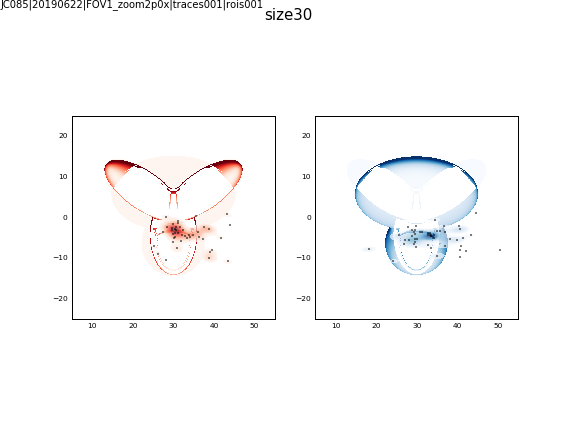

8.56499526583
size30


In [228]:

fig, axes = pl.subplots(1,2) #= pl.figure(figsize=(8, 6)) # = pl.subplots(2,1)
fig.patch.set_alpha(1)

ax=axes[0]
# Screen visualization ----------------------------------------------------
ax.set_facecolor('w')
#ax.set_xlim([screen_bounds[1], screen_bounds[3]])
#ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_xlim([xpos-25, xpos+25])
ax.set_ylim([ypos-25, ypos+25])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)


# Draw stimulus diff image:
diff_img = images['D1']-images['D2']
#(score, grad, diff) = compare_ssim(images['D1'], images['D2'], full=True, gradient=True)
imr = resize_image_to_coords(diff_img, size_deg=curr_sz, pix_per_deg=pix_per_degW)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
#im0 = ax.imshow(thresh_ma, cmap='gray', extent=extent, vmin=0, vmax=0.9)
im0 = ax.imshow(thresh_ma - images['D2'], cmap='Reds', extent=extent)

# Overlay density plot:  
bounds = [screen_bounds[1], screen_bounds[3], screen_bounds[0], screen_bounds[2]]
#ax.imshow(np.flipud(zz_neg_ma), extent=bounds, cmap='Reds', alpha=0.7)
ax.imshow(np.flipud(zz_pos_ma), extent=bounds, cmap='Reds', alpha=0.7)
ax.scatter(obs_pos[:, 0], obs_pos[:, 1], alpha=0.5, marker='+', color='k', s=1)



ax = axes[1]
ax.set_xlim([xpos-25, xpos+25])
ax.set_ylim([ypos-25, ypos+25])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

#im0 = ax.imshow(thresh_ma, cmap='gray', extent=extent, vmin=0, vmax=0.9)
im1 = ax.imshow(thresh_ma - images['D1'], cmap='Blues', extent=extent)

# Overlay density plot:  
bounds = [screen_bounds[1], screen_bounds[3], screen_bounds[0], screen_bounds[2]]
#ax.imshow(np.flipud(zz_neg_ma), extent=bounds, cmap='Reds', alpha=0.7)
ax.imshow(np.flipud(zz_neg_ma), extent=bounds, cmap='Blues', alpha=0.7)
ax.scatter(obs_neg[:, 0], obs_neg[:, 1], alpha=0.5, marker='+', color='k', s=1)

label_figure(fig, data_identifier)

fig.suptitle('%s' % transform_str)

pl.savefig(os.path.join(svm_output_dir, '%s_pos_vs_neg_weights_overlaid_diff_image_%s.png' % (rf_exp_name, transform_str) ))
print transform_str

In [83]:

diff_img = images['D1'].astype('float') - images['D2'].astype(float)

d1, d2 = diff_img.shape


img1 = diff_img.copy()
img2 = diff_img.copy()

#neg_img = np.ma.array(diff_img.copy(), mask=diff_img>=0)
#pos_img = np.ma.array(diff_img.copy(), mask=diff_img<=0)
pos_img = diff_img.copy()
pos_img[diff_img<=0] = np.nan

neg_img = diff_img.copy()
neg_img[diff_img>=0] = np.nan


o_min = pos_density.min()
o_max = pos_density.max()
pos_conv = convert_range(pos_density, newmin=0, newmax=255, oldmin=o_min, oldmax=o_max)


fig, axes = pl.subplots(1,2)
#pl.figure()


ax = axes[0]
ax.set_facecolor('r')
merge = np.zeros((d1, d2, 3), dtype=diff_img.dtype) #* np.nan
merge[:, :, 0] = neg_img #np.abs(neg_img)
merge[:, :, 2] = pos_img #np.abs(pos_img)
#merge[:, :, 1] = pos_conv

merge2 = merge.copy()
merge2[merge==0] = np.nan
ax.imshow(merge)

pl.subplot(1,2,2)

pl.imshow(merge)


NameError: name 'pos_density' is not defined

In [84]:
def mask_color_img(img, mask, color=[0, 255, 255], alpha=0.3):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 255, 255] is yellow.
    alpha: float [0, 1]. 
    
    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    out = img.copy()
    img_layer = img.copy()
    img_layer[mask] = color
    out = cv2.addWeighted(img_layer, alpha, out, 1 - alpha, 0, out)
    return(out)


def human_imshow(img):
    return(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [85]:
zz_pos_ma.min()

0.0030003772675036506

<IPython.core.display.Javascript object>


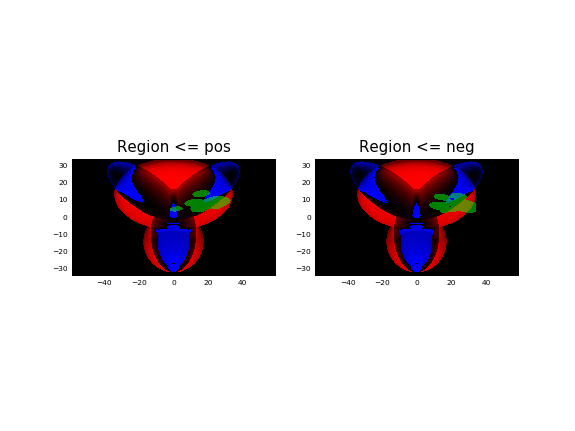

8.56499526583
8.56499526583


In [187]:
pos_img = diff_img.copy()
pos_img[diff_img<=0] = np.nan

neg_img = diff_img.copy()
neg_img[diff_img>=0] = np.nan



merge = np.zeros((d1, d2, 3), dtype=diff_img.dtype) #* np.nan
merge[:, :, 0] = neg_img #np.abs(neg_img)
merge[:, :, 2] = pos_img #np.abs(pos_img)
merge = merge.astype('uint8')

pos_density = np.flipud(zz_pos_ma)
neg_density = np.flipud(zz_neg_ma)

# pos_conv = convert_range(pos_density, newmin=0, newmax=255,\
#                          oldmin=pos_density.min(), oldmax=pos_density.max())
# neg_conv = convert_range(neg_density, newmin=0, newmax=255,\
#                          oldmin=neg_density.min(), oldmax=neg_density.max())

# ax.imshow(pos_conv)

fig, axes = pl.subplots(1, 2)
#im = axes[0].imshow(pos_conv)
#pl.colorbar(im)

for ai, ax in enumerate(axes):
    ax.set_facecolor('w')
    ax.set_xlim([screen_bounds[1], screen_bounds[3]])
    ax.set_ylim([screen_bounds[0], screen_bounds[2]])
    #ax.set_xlim([xpos-25, xpos+25])
    #ax.set_ylim([ypos-25, ypos+25])
    ax.set_aspect(screen_aspect)
    ax.tick_params(axis='both', which='both', length=0, labelsize=6)


    imr = resize_image_to_coords(diff_img, size_deg=curr_sz, pix_per_deg=pix_per_degW)
    # extent : scalars (left, right, bottom, top), optional, default: None
    extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
    ax.imshow(merge, extent=extent)

    bounds = [screen_bounds[1], screen_bounds[3], screen_bounds[0], screen_bounds[2]]
    #ax.imshow(pos_conv, extent=bounds)

    for cls, ax in zip(['pos', 'neg'], axes.flat):
        if cls == 'pos':
            cr_nuclei = np.where(pos_density > 0.001)
        elif cls == 'neg':
            cr_nuclei = np.where(neg_density > 0.001)

        foo = mask_color_img(merge, cr_nuclei, [0, 255, 0], alpha=.5)
        ax.set_title('Region <= {}'.format(cls))
        ax.imshow(human_imshow(foo), extent=bounds)
        i += 1
pl.savefig(os.path.join(svm_output_dir, 'RGB_overlay_pos_v_neg_%s.png' % transform_str))

In [491]:
pos_conv.shape

(618, 1080)

<IPython.core.display.Javascript object>


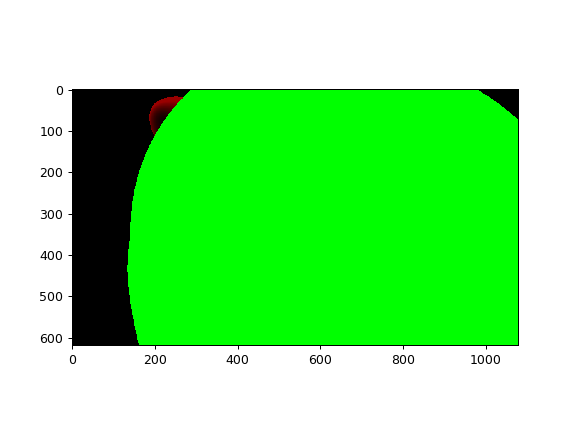

In [498]:
pl.figure()
merge[cr_nuclei] = [0, 255, 0]
pl.imshow(merge)

<IPython.core.display.Javascript object>


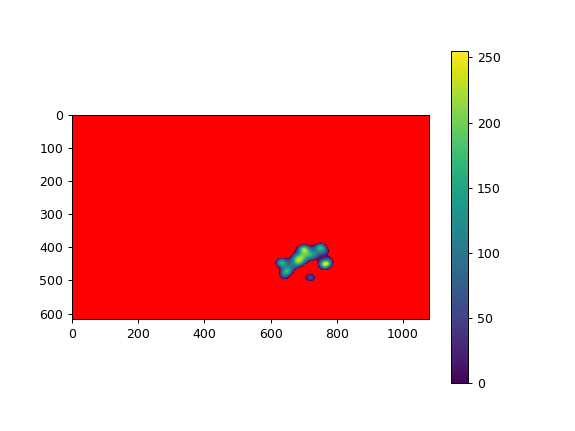

In [476]:
fig, ax = pl.subplots()
ax.set_facecolor('r')
im=ax.imshow(neg_conv)
pl.colorbar(im)

<IPython.core.display.Javascript object>


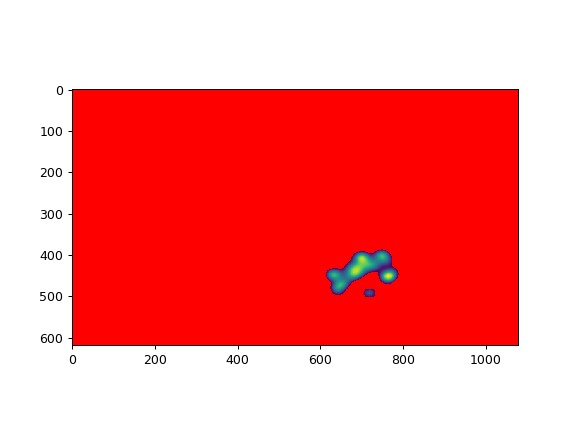

In [429]:
#neg_img = np.ma.array(diff_img.copy(), mask=diff_img<0)
fig, ax = pl.subplots() #.figure()
ax.set_facecolor('r')
pl.imshow(pos_conv)

<IPython.core.display.Javascript object>


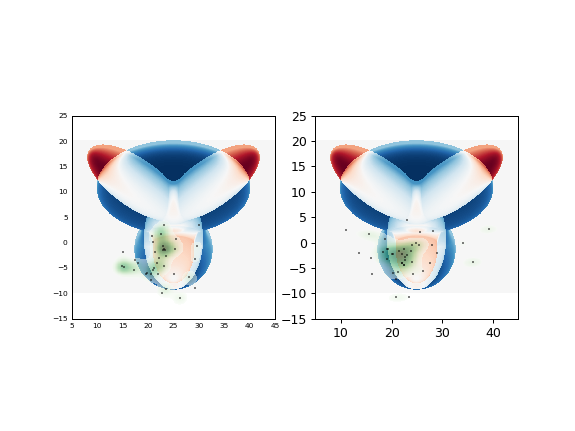

8.56499526583


In [86]:
zoom = 20

fig, axes = pl.subplots(1,2) #= pl.figure(figsize=(8, 6)) # = pl.subplots(2,1)
fig.patch.set_alpha(1)

ax=axes[0]
# Screen visualization ----------------------------------------------------
ax.set_facecolor('w')
#ax.set_xlim([screen_bounds[1], screen_bounds[3]])
#ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_xlim([xpos-zoom, xpos+zoom])
ax.set_ylim([ypos-zoom, ypos+zoom])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

diff_img = images['D1'].astype(float)-images['D2'].astype(float)
imr = resize_image_to_coords(diff_img, size_deg=curr_sz, pix_per_deg=pix_per_degW)
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
im1 = ax.imshow(diff_img, cmap='RdBu', vmin=-255, vmax=255, extent=extent)
#pl.colorbar(im1)

# Overlay density plot:  
bounds = [screen_bounds[1], screen_bounds[3], screen_bounds[0], screen_bounds[2]]
ax.imshow(np.flipud(zz_pos_ma), extent=bounds, cmap='Greens', alpha=0.5)
ax.scatter(obs_pos[:, 0], obs_pos[:, 1], alpha=0.5, marker='+', color='k', s=1)

ax=axes[1]
ax.set_xlim([xpos-zoom, xpos+zoom])
ax.set_ylim([ypos-zoom, ypos+zoom])
ax.set_aspect(screen_aspect)
im1 = ax.imshow(diff_img, cmap='RdBu', vmin=-255, vmax=255, extent=extent)
#pl.colorbar(im1)

# Overlay density plot:  
bounds = [screen_bounds[1], screen_bounds[3], screen_bounds[0], screen_bounds[2]]
ax.imshow(np.flipud(zz_neg_ma), extent=bounds, cmap='Greens', alpha=0.5)
ax.scatter(obs_neg[:, 0], obs_neg[:, 1], alpha=0.5, marker='+', color='k', s=1)



70

# Calculate amount of overlap bw RF and SHAPE

In [199]:
from shapely import geometry 

def get_image_rf_overlap(sx, sy, th, x0, y0, img=None, stimulus_params={}, sigma_scale=2.36):
    
    s_ell = create_ellipse((x0, y0), (abs(sx)*sigma_scale/2., abs(sy)*sigma_scale/2.), np.rad2deg(th))

    intersection = calculate_image_intersection(s_ell, img, 
                                                img_sz=stimulus_params['size'],
                                                xpos=stimulus_params['xpos'], ypos=stimulus_params['ypos'], 
                                                screen_bounds=stimulus_params['screen_bounds'],
                                                pix_per_deg=stimulus_params['pix_per_deg'])
    overlap = intersection.area / s_ell.area
    
    return overlap

def calculate_image_intersection(s_ell, img, img_sz=30, xpos=0, ypos=0,
                            screen_bounds=[-33.6615, -58.7792, 33.6615, 58.7792], pix_per_deg=10):
    
    fig, ax = pl.subplots()

    # Screen visualization ----------------------------------------------------
    ax.set_xlim([screen_bounds[1], screen_bounds[3]])
    ax.set_ylim([screen_bounds[0], screen_bounds[2]])
    ax.set_aspect(screen_aspect)

    # Draw stimulus diff image:
    imr = resize_image_to_coords(img, size_deg=img_sz, pix_per_deg=pix_per_deg)
    # extent : scalars (left, right, bottom, top), optional, default: None
    extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
    #im0 = ax.imshow(img, cmap='gray', extent=extent)

    s_poly1 = get_poly_from_imshow(img, extent, ax)

    # 
    #s_ell = create_ellipse((x0, y0), (abs(sx)*sigma_scale/2., abs(sy)*sigma_scale/2.), np.rad2deg(th))

    intersection = s_ell.intersection(s_poly1)
    
    pl.close(fig)

    return intersection


def get_poly_from_imshow(img, extent, ax):

    im_bw = img.copy()
    im_bw[img>0] = 1
    im0 = ax.contour(np.flipud(im_bw), cmap='gray', extent=extent)

    col = im0.collections[0]
    for contour_path in col.get_paths(): 
        # Create the polygon for this intensity level
        # The first polygon in the path is the main one, the following ones are "holes"
        for ncp,cp in enumerate(contour_path.to_polygons()):
            x = cp[:,0]
            y = cp[:,1]
            new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])
            if ncp == 0:
                poly = new_shape
            else:
                # Remove the holes if there are any
                poly = poly.difference(new_shape)
                # Can also be left out if you want to include all rings

        # do something with polygon
        print poly.area
    im0.set_alpha(0) #(False)

    return poly


<IPython.core.display.Javascript object>


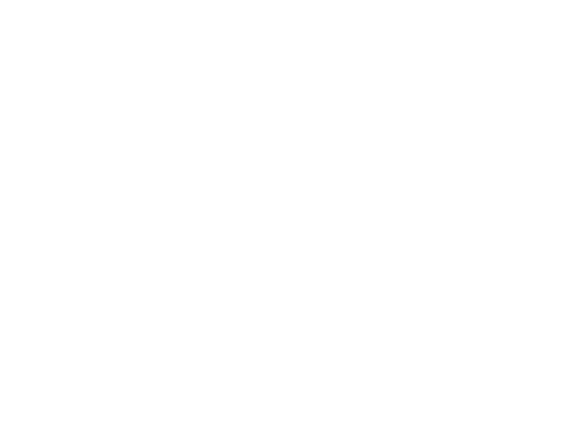

8.56499526583
450.043338345


<IPython.core.display.Javascript object>


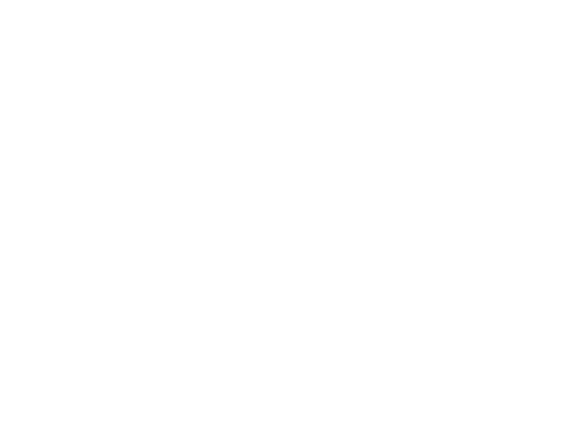

8.56499526583
450.043338345


<IPython.core.display.Javascript object>


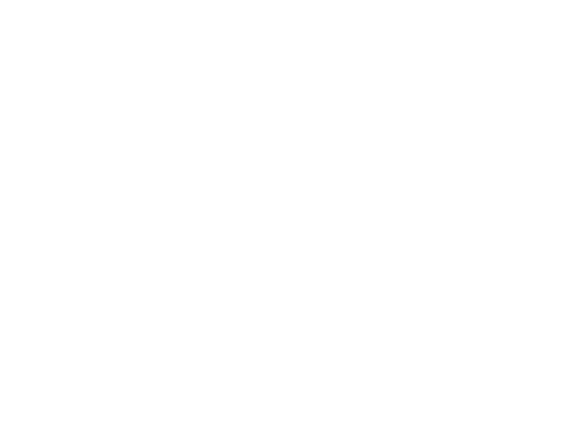

8.56499526583
450.043338345


<IPython.core.display.Javascript object>


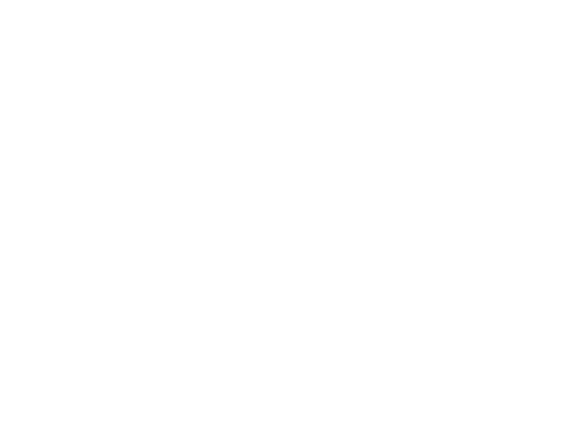

8.56499526583
586.439268907


<IPython.core.display.Javascript object>


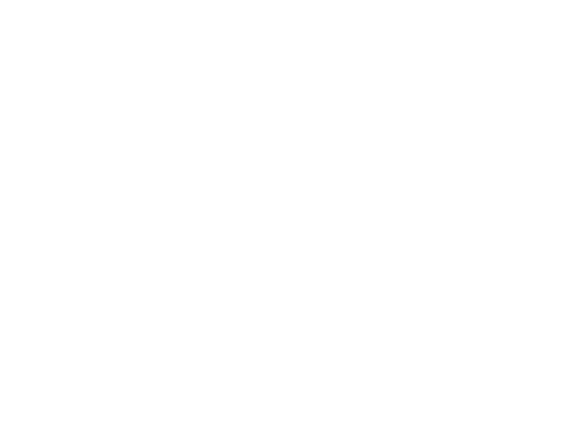

8.56499526583
586.439268907


<IPython.core.display.Javascript object>


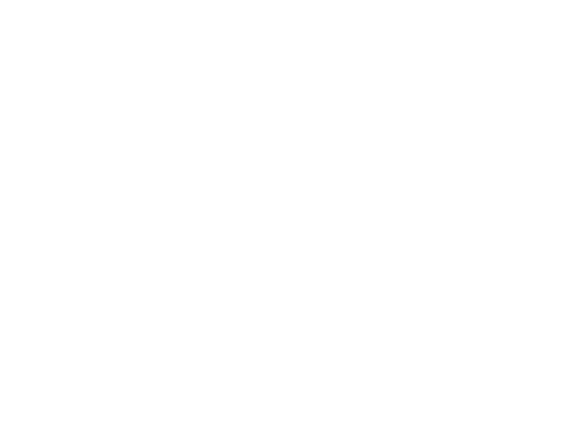

8.56499526583
586.439268907


In [200]:
#overlaps = dict((imname, []) for imname in images.keys())

stimulus_params = {'xpos': xpos,
                  'ypos': ypos,
                  'size': curr_sz,
                  'pix_per_deg': pix_per_degW,
                  'screen_bounds': screen_bounds}

overlaps = dict()
for imname in images.keys():
    
    overlaps[imname] = [get_image_rf_overlap(*rf_fits_df.loc[roi], img=images[imname],\
                                             stimulus_params=stimulus_params) for roi in rfs_in_blobs]
    
                        

#### Plot distN of overlap of RFs for each objects:

In [201]:
# fig, ax = pl.subplots()

# sns.distplot(overlaps['D1'], ax=ax, norm_hist=0, kde=False,
#             rug=False, label='m0',
#             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.9,
#                       'normed': 0, "color": 'r'})


# sns.distplot(overlaps['D2'], ax=ax, norm_hist=0, kde=False,
#             rug=False, label='m100',
#             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.9,
#                       'normed': 0, "color": 'b'})
# ax.set_xlim([0, 1])
# ax.set_xlabel('fraction RF overlap')
# ax.set_ylabel('counts')

# sns.despine(trim=True, offset=4, ax=ax)
# ax.legend()

# ax.set_title('%s' % transform_str)

# label_figure(fig, data_identifier)
# pl.savefig(os.path.join(svm_output_dir, '%s_AvB_distn_of_RF_overlap_%s.png' % (rf_exp_name, transform_str) ))

In [202]:
X.head()

,33,49,69
0,0.242038,0.343985,0.246615
1,0.170805,0.209652,0.233906
2,0.153678,0.263676,0.236603
3,0.167571,0.288582,0.227002
4,0.244504,0.085158,0.370102


In [203]:

X = sample_data[rfs_in_blobs].iloc[train_ixs].reset_index(drop=True) #[train_configs]
y = np.array([sdf[class_name][c] for c in sample_labels[train_ixs]])

<IPython.core.display.Javascript object>


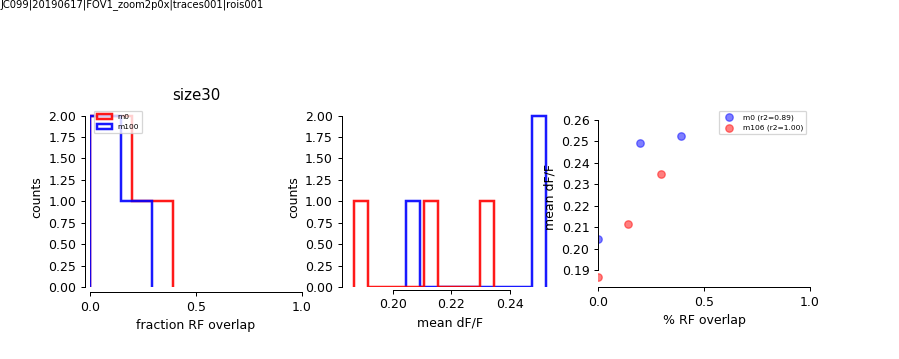

(0.89405889680618134, 0.29569108033621444)
(0.99914369840036243, 0.026347504897787269)


In [204]:
fig, axes = pl.subplots(1, 3, figsize=(10,4)) #roi = 5
fig.patch.set_alpha(1)

meanr0 = [X[roi][y==0].mean() for roi in rfs_in_blobs]
meanr1 = [X[roi][y==106].mean() for roi in rfs_in_blobs]

ax = axes[0]
weights0 = np.ones_like(meanr0) / float(len(meanr0))
weights1 = np.ones_like(meanr1) / float(len(meanr1))
sns.distplot(overlaps['D1'], ax=ax, norm_hist=0, kde=False,
            rug=False, label='m0',
            hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.9,
                      'normed': 0, "color": 'r'}) #, 'weights': weights0})
sns.distplot(overlaps['D2'], ax=ax, norm_hist=0, kde=False,
            rug=False, label='m100',
            hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.9,
                      'normed': 0, "color": 'b'}) #, 'weights': weights1})
ax.set_xlim([0, 1])
ax.set_xlabel('fraction RF overlap')
ax.set_ylabel('counts')
ax.set_xticks([0, 0.5, 1])
sns.despine(trim=True, offset=4, ax=ax)
ax.legend(loc='upper left', fontsize=6)
ax.set_title('%s' % transform_str)



ax = axes[1]
ax.hist(meanr0, color='b', alpha=0.9, label='0', histtype='step', linewidth=2)
ax.hist(meanr1, color='r', alpha=0.9, label='106', histtype='step', linewidth=2)
sns.despine(trim=True, offset=2, ax=ax)
ax.set_xlabel('mean dF/F')
ax.set_ylabel('counts')

ax = axes[2]
pearsons0 = stats.pearsonr(overlaps['D1'], meanr0)
print(pearsons0)
pearsons1 = stats.pearsonr(overlaps['D2'], meanr1)
print(pearsons1)
ax.scatter(overlaps['D1'], meanr0, color='b', alpha=0.5, label='m0 (r2=%.2f)' % pearsons0[0])
ax.scatter(overlaps['D2'], meanr1, color='r', alpha=0.5, label='m106 (r2=%.2f)' % pearsons1[0])
ax.set_xlabel('% RF overlap')
ax.set_ylabel('mean dF/F')
ax.set_xticks([0, 0.5, 1.0])
ax.legend(loc='upper right', fontsize=6)



ax.set_xlim([0, 1])
sns.despine(ax=ax, top=True, right=True, trim=True)

pl.subplots_adjust(wspace=0.2, top=0.7, bottom=0.2, left=0.1)

label_figure(fig, data_identifier)

pl.savefig(os.path.join(output_dir, '%s_AvsB_rf_overlap_mean_response_%s.png' % (rf_exp_name, transform_str)))

In [271]:
X.shape

(60, 70)

In [337]:
images.keys()

['D2', 'D1']

<IPython.core.display.Javascript object>


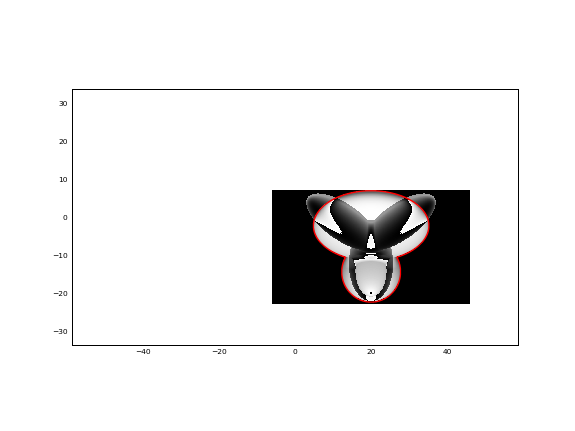

8.56499526583
586.439268907


In [299]:
fig, ax = pl.subplots()

# Screen visualization ----------------------------------------------------
ax.set_xlim([screen_bounds[1], screen_bounds[3]])
ax.set_ylim([screen_bounds[0], screen_bounds[2]])
ax.set_aspect(screen_aspect)
ax.tick_params(axis='both', which='both', length=0, labelsize=6)

# Draw stimulus diff image:
diff_img = images['D1']-images['D2']
imr = resize_image_to_coords(diff_img, size_deg=curr_sz, pix_per_deg=pix_per_degW)
# extent : scalars (left, right, bottom, top), optional, default: None
extent=[-imr.shape[1]/2. + xpos, imr.shape[1]/2. + xpos, -imr.shape[0]/2. + ypos, imr.shape[0]/2. + ypos]
ax.imshow(diff_img, cmap='gray', extent=extent)


im_bw = img.copy()
im_bw[img>0] = 1
im0 = ax.contour(np.flipud(im_bw), cmap='gray', extent=extent)

    
col = im0.collections[0]
for contour_path in col.get_paths(): 
    # Create the polygon for this intensity level
    # The first polygon in the path is the main one, the following ones are "holes"
    for ncp,cp in enumerate(contour_path.to_polygons()):
        x = cp[:,0]
        y = cp[:,1]
        new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(x,y)])
        if ncp == 0:
            poly = new_shape
        else:
            # Remove the holes if there are any
            poly = poly.difference(new_shape)
            # Can also be left out if you want to include all rings

    # do something with polygon
    print poly.area

im0.set_alpha(0) #(False)

    
    
v_poly = np.array(poly.exterior.coords.xy)
p_poly = Polygon(v_poly.T, edgecolor='r', alpha=1, facecolor='none', lw=1)
ax.add_patch(p_poly)




# Retino data

In [79]:
magratios, phases, traces = do_retino_analysis_on_raw(S.experiments['retino'])

[-22.31640161 -22.29640484 -22.27640806 ...,  22.27640806  22.29640484
  22.31640161]
Target freq: 0.240 Hz


#### Look at best cell

In [77]:
magratios[magratios['right'] == magratios.max()['right']]

,top,right,left,bottom
67,0.030328,0.049055,0.035195,0.045492


<IPython.core.display.Javascript object>


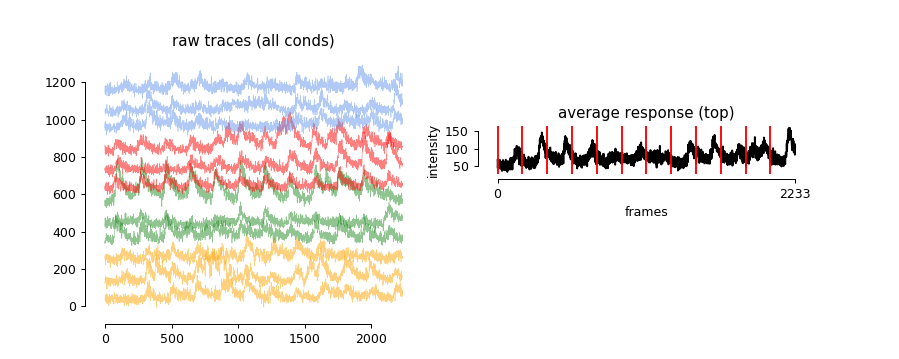

(2233,)


In [107]:
roi = 67

curr_cond = 'right' #max_mod_condn
n_frames = S.experiments['retino'].data.info['stimulus']['nframes']
n_files = S.experiments['retino'].data.info['ntiffs']
cycle_starts = S.experiments['retino'].data.info['stimulus']['cycle_start_ixs']

fig = pl.figure(figsize=(10,4))
gspec = gridspec.GridSpec(ncols=2, nrows=4, height_ratios=[1, 1, 1, 1])

# ax1 = fig.add_subplot(gspec[0, 0])
# ax1.imshow(np.reshape(S.experiments['retino'].data.traces[roi], cnm.dims, order='F'))
# ax1.set_title('rid %i' % rid)
# ax1.axis('off')

offset=100
trials_by_cond = S.experiments['retino'].data.info['trials']
colordict = {'right': 'forestgreen', 'left': 'orange',
            'top': 'cornflowerblue', 'bottom': 'red'}
ax2 = fig.add_subplot(gspec[:, 0])
tmat = np.reshape(S.experiments['retino'].data.traces[roi], (n_frames, n_files), order='F')
grouped_trials = copy.copy(trials_by_cond['left'])
for cond in ['right', 'bottom', 'top']:
    grouped_trials.extend(trials_by_cond[cond])
for ti, tnum in enumerate(grouped_trials): #range(tmat.shape[1]):
    curr_cond = [cond for cond, tlist in trials_by_cond.items() if tnum in tlist][0]
    curr_color = colordict[curr_cond]
    ax2.plot(tmat[:, tnum-1] + ti*offset, color=curr_color, alpha=0.5, lw=0.5)
ax2.set_title('raw traces (all conds)')

ax3 = fig.add_subplot(gspec[1, 1])
avg = traces[curr_cond][roi]
print(avg.shape)
ax3.plot(avg, 'k')
ax3.set_xticks([0, n_frames])
for cyc in cycle_starts:
    ax3.axvline(x=cyc, color='r')
ax3.set_title('average response (%s)' % curr_cond)
ax3.set_ylabel('intensity')
ax3.set_xlabel('frames')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(top=0.85, left=0.1, hspace=0.5)
#label_figure(fig, data_identifier)

In [113]:
magratios.loc[67]

top       0.030328
right     0.049055
left      0.035195
bottom    0.045492
Name: 67, dtype: float64

In [114]:
magratio_thr = 0.01
retino_rois = [r for r in magratios.index.tolist() if any(magratios.loc[r] > magratio_thr)]
print(len(retino_rois))
                                                          

132


In [110]:
magratios.loc[roi]

top       0.030328
right     0.049055
left      0.035195
bottom    0.045492
Name: 67, dtype: float64